## Fig2. GTEx results of 4 models 

### a. Heatmaps for GTEx dataset. To plot the heatmap for all/change only dataset, simply change suffix to "all" or "chgOnly".

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import pandas as pd
import os

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(6.4, 4.8))
sns.set(font_scale = 2)

output_dir = '/home/diwu/project/Ladibug/analysis/figures/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
def check_offset_perc(preds, labels):
    length = len(preds)
    diff = abs(np.array(preds) - np.array(labels))
    offset_count = sum(diff>0.2)
    offset_perc = offset_count/length
    print("offset percentage:", offset_perc, offset_count, length)
    return offset_perc

def cal_dpsi(psi1, psi2):
    epsilon = np.random.uniform(0.001, 0.002)
    dpsi = psi2 - psi1
    dpsi_inc = abs(max(dpsi, epsilon))
    dpsi_exc = abs(min(dpsi, epsilon))
    return [dpsi_inc, dpsi_exc]


def cal_score(data, auc_dpsi_plus, auc_dpsi_minus, prc_dpsi_plus, prc_dpsi_minus):
    roc_prc = [None,None]
    roc_auc = [None,None]
    labels = np.array(data[0])
    preds = np.array(data[1])
    for i in range(2):
        temp_label = labels[:,i]
        temp_pred = preds[:,i]
        temp_label[temp_label<=0.05] = 0
        temp_label[temp_label>0.15] = 1
        temp_pred = temp_pred[(temp_label == 0) | (temp_label == 1)]
        temp_label = temp_label[(temp_label == 0) | (temp_label == 1)]
        lr_precision, lr_recall, _ = precision_recall_curve(temp_label, temp_pred)
        roc_prc[i] = round(auc(lr_recall, lr_precision), 3)
        fpr, tpr, _ = roc_curve(temp_label, temp_pred)
        roc_auc[i] = round(auc(fpr, tpr), 3)
    print("AUROC:", roc_auc)
    print("AUPRC:", roc_prc)
    auc_dpsi_plus.append(roc_auc[0])
    auc_dpsi_minus.append(roc_auc[1])
    prc_dpsi_plus.append(roc_prc[0])
    prc_dpsi_minus.append(roc_prc[1])
    # return roc_auc, roc_prc
    

def get_corr(hash_data, key):
    heart_brain = [[],[]]   #label, pred
    heart_liver = [[],[]]
    brain_liver = [[],[]]

    auc_dpsi_plus = []
    auc_dpsi_minus = []
    prc_dpsi_plus = []
    prc_dpsi_minus = []
    labels_list = hash_data["Label"].values
    preds_list = hash_data[key].values
    tissues_list = hash_data["Tissue"].values
    for i, tissues in enumerate(tissues_list):
        labels = labels_list[i]
        preds = preds_list[i]
        tissues = {k:i for i,k in enumerate(tissues)}
        if "Heart_Atrial_Appendage" in tissues:
            if "Brain_Cerebellum" in tissues:
                heart_brain[0].append(cal_dpsi(labels[tissues["Heart_Atrial_Appendage"]], labels[tissues["Brain_Cerebellum"]]))
                heart_brain[1].append(cal_dpsi(preds[tissues["Heart_Atrial_Appendage"]], preds[tissues["Brain_Cerebellum"]]))
                
            if "Liver" in tissues:
                heart_liver[0].append(cal_dpsi(labels[tissues["Heart_Atrial_Appendage"]], labels[tissues["Liver"]]))
                heart_liver[1].append(cal_dpsi(preds[tissues["Heart_Atrial_Appendage"]], preds[tissues["Liver"]]))
        if "Brain_Cerebellum" in tissues and "Liver" in tissues:
            brain_liver[0].append(cal_dpsi(labels[tissues["Brain_Cerebellum"]], labels[tissues["Liver"]]))
            brain_liver[1].append(cal_dpsi(preds[tissues["Brain_Cerebellum"]], preds[tissues["Liver"]]))
    print("heart_brain:")
    cal_score(heart_brain, auc_dpsi_plus, auc_dpsi_minus, prc_dpsi_plus, prc_dpsi_minus)
    print("heart_liver:")
    cal_score(heart_liver, auc_dpsi_plus, auc_dpsi_minus, prc_dpsi_plus, prc_dpsi_minus)
    print("brain_liver:")
    cal_score(brain_liver, auc_dpsi_plus, auc_dpsi_minus, prc_dpsi_plus, prc_dpsi_minus)
    return auc_dpsi_plus, auc_dpsi_minus, prc_dpsi_plus, prc_dpsi_minus

<Figure size 1920x1440 with 0 Axes>

total: 2456
offset percentage: 0.21579804560260588 530 2456
Spearman: 0.746
Pearson: 0.817


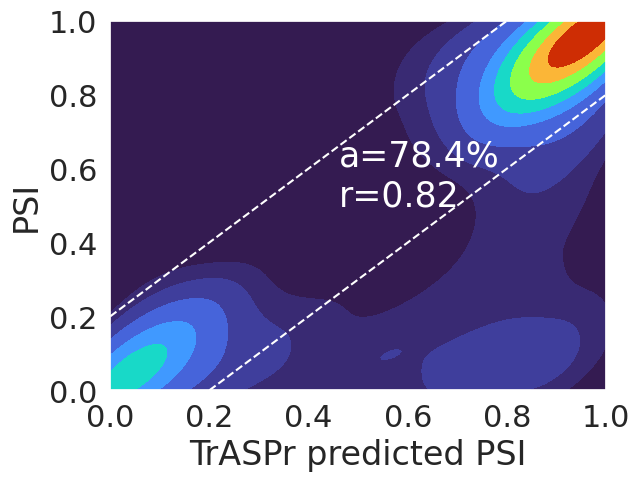

In [16]:
sns.set(font_scale = 2)
POS_THRESHOLD_ABS = 0.15
NEG_THRESHOLD_ABS = 0.05

data_dir = "./data/GTEx_data.tsv"
suffix = "all"
# suffix = "chgOnly"

data = pd.read_csv(data_dir, sep='\t', header=0)

if suffix == "all":
    labels = data["Label"].values
    preds = data["TrASPr_pred"].values
else:
    labels = data[data["Change_case"]==True]["Label"].values
    preds = data[data["Change_case"]==True]["TrASPr_pred"].values

total = len(labels)
print("total:", total)

spearman_score = round(spearmanr(labels, preds)[0],3)
pearson_score = round(pearsonr(labels, preds)[0],3)
offset_perc = check_offset_perc(preds, labels)
print("Spearman:",spearman_score)
print("Pearson:",pearson_score)


if suffix == "all":
    vmax = 11
else:
    vmax = 4.0

ax = sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0)
norm = Normalize(0, vmax)
for collection in ax.collections:
    collection.set_norm(norm)

plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.46,0.5,"a=" + str(round(1-offset_perc, 3)*100) + "%\nr=" + str("%.2f" % round(pearson_score,2)), c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('TrASPr predicted PSI')
plt.ylabel('PSI')


if suffix == "all":
    x_pos = 1.5
else:
    x_pos = 0.75
    
plt.show()

total: 2456
offset percentage: 0.2931596091205212 720 2456
Spearman: 0.672
Pearson: 0.795


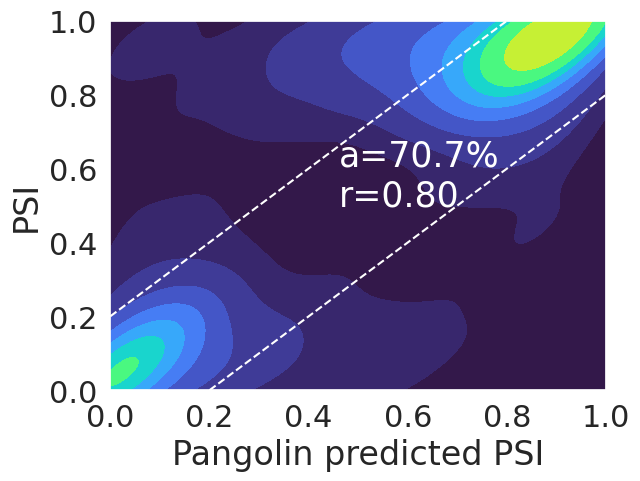

In [17]:
if suffix == "all":
    labels = data["Label"].values
    preds = data["Pangolin_pred"].values
else:
    labels = data[data["Change_case"]==True]["Label"].values
    preds = data[data["Change_case"]==True]["Pangolin_pred"].values

total = len(labels)
print("total:", total)

spearman_score = round(spearmanr(labels, preds)[0],3)
pearson_score = round(pearsonr(labels, preds)[0],3)
offset_perc = check_offset_perc(preds, labels)
print("Spearman:",spearman_score)
print("Pearson:",pearson_score)

ax = sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0)
norm = Normalize(0, vmax)
for collection in ax.collections:
    collection.set_norm(norm)

plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.46,0.5,"a=" + str(round(1-offset_perc, 3)*100) + "%\nr=" + str("%.2f" % round(pearson_score,2)), c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('Pangolin predicted PSI')
plt.ylabel('PSI')
    
plt.show()

total: 2456
offset percentage: 0.33957654723127034 834 2456
Spearman: 0.593
Pearson: 0.674


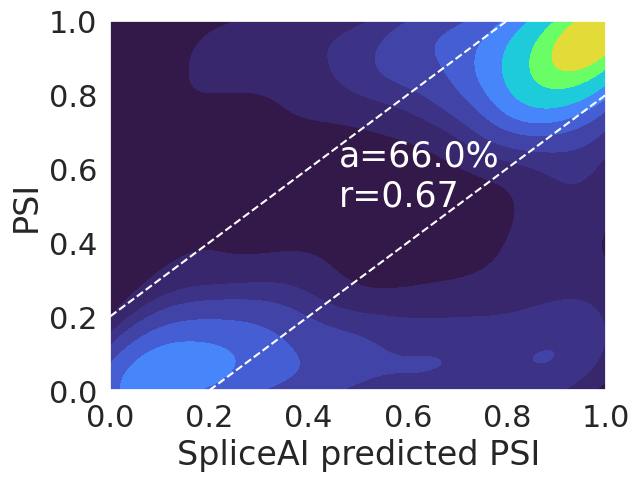

In [19]:
if suffix == "all":
    labels = data["Label"].values
    preds = data["SpliceAI_pred"].values
else:
    labels = data[data["Change_case"]==True]["Label"].values
    preds = data[data["Change_case"]==True]["SpliceAI_pred"].values

total = len(labels)
print("total:", total)

spearman_score = round(spearmanr(labels, preds)[0],3)
pearson_score = round(pearsonr(labels, preds)[0],3)
offset_perc = check_offset_perc(preds, labels)
print("Spearman:",spearman_score)
print("Pearson:",pearson_score)

ax = sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0)
norm = Normalize(0, vmax)
for collection in ax.collections:
    collection.set_norm(norm)

plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.46,0.5,"a=" + str(round(1-offset_perc, 3)*100) + "%\nr=" + str("%.2f" % round(pearson_score,2)), c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('SpliceAI predicted PSI')
plt.ylabel('PSI')
plt.show()

total: 2456
offset percentage: 0.3534201954397394 868 2456
Spearman: 0.57
Pearson: 0.657


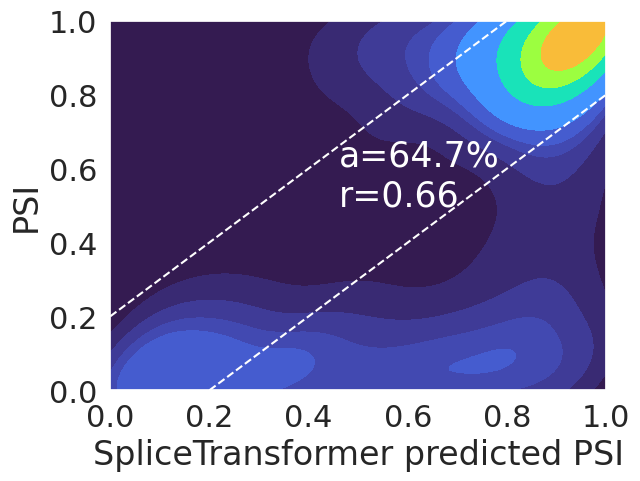

In [20]:
if suffix == "all":
    labels = data["Label"].values
    preds = data["SpliceTF_pred"].values
else:
    labels = data[data["Change_case"]==True]["Label"].values
    preds = data[data["Change_case"]==True]["SpliceTF_pred"].values

total = len(labels)
print("total:", total)

spearman_score = round(spearmanr(labels, preds)[0],3)
pearson_score = round(pearsonr(labels, preds)[0],3)
offset_perc = check_offset_perc(preds, labels)
print("Spearman:",spearman_score)
print("Pearson:",pearson_score)

ax = sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0)
norm = Normalize(0, vmax)
for collection in ax.collections:
    collection.set_norm(norm)

plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.46,0.5,"a=" + str(round(1-offset_perc, 3)*100) + "%\nr=" + str("%.2f" % round(pearson_score,2)), c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('SpliceTransformer predicted PSI')
plt.ylabel('PSI')
plt.show()

### b. Bar plot for TrASPr and Pangolin for tissue-pair predictions comparison.

In [73]:
# prepare TrASPr tissue-part results
data_dir = "./data/GTEx_TrASPr_dPSI_preds.tsv"
data = pd.read_csv(data_dir, sep='\t', header=0)

traspr_heart_brain = [[],[]]
traspr_heart_liver = [[],[]]
traspr_brain_liver = [[],[]]

traspr_auc_dpsi_plus = []
traspr_auc_dpsi_minus = []
traspr_prc_dpsi_plus = []
traspr_prc_dpsi_minus = []

tmp_data = data[(data["Tissue1"]=="Heart_Atrial_Appendage") & (data["Tissue2"]=="Brain_Cerebellum") | (data["Tissue2"]=="Heart_Atrial_Appendage") & (data["Tissue1"]=="Brain_Cerebellum")]
traspr_heart_brain[0] = tmp_data["Label"].apply(lambda x: [float(v) for v in x.split(',')[1:]]).values.tolist()
traspr_heart_brain[1] = tmp_data["TrASPr_pred"].apply(lambda x: [float(v) for v in x.split(',')[1:]]).values.tolist()

tmp_data = data[(data["Tissue1"]=="Heart_Atrial_Appendage") & (data["Tissue2"]=="Liver") | (data["Tissue2"]=="Heart_Atrial_Appendage") & (data["Tissue1"]=="Liver")]
traspr_heart_liver[0] = tmp_data["Label"].apply(lambda x: [float(v) for v in x.split(',')[1:]]).values.tolist()
traspr_heart_liver[1] = tmp_data["TrASPr_pred"].apply(lambda x: [float(v) for v in x.split(',')[1:]]).values.tolist()

tmp_data = data[(data["Tissue1"]=="Liver") & (data["Tissue2"]=="Brain_Cerebellum") | (data["Tissue2"]=="Liver") & (data["Tissue1"]=="Brain_Cerebellum")]
traspr_brain_liver[0] = tmp_data["Label"].apply(lambda x: [float(v) for v in x.split(',')[1:]]).values.tolist()
traspr_brain_liver[1] = tmp_data["TrASPr_pred"].apply(lambda x: [float(v) for v in x.split(',')[1:]]).values.tolist()

print("heart_brain:")
cal_score(traspr_heart_brain, traspr_auc_dpsi_plus, traspr_auc_dpsi_minus, traspr_prc_dpsi_plus, traspr_prc_dpsi_minus)
print("heart_liver:")
cal_score(traspr_heart_liver, traspr_auc_dpsi_plus, traspr_auc_dpsi_minus, traspr_prc_dpsi_plus, traspr_prc_dpsi_minus)
print("brain_liver:")
cal_score(traspr_brain_liver, traspr_auc_dpsi_plus, traspr_auc_dpsi_minus, traspr_prc_dpsi_plus, traspr_prc_dpsi_minus)

# prepare Pangolin tissue-part results
data_dir = "./data/GTEx_data.tsv"
data = pd.read_csv(data_dir, sep='\t', header=0)
pangolin_data = data.groupby("ID").agg({
    "Label": list,
    "Tissue":list,
    "Pangolin_pred": list,
}).reset_index()
pangolin_auc_dpsi_plus, pangolin_auc_dpsi_minus, pangolin_prc_dpsi_plus, pangolin_prc_dpsi_minus = get_corr(pangolin_data, "Pangolin_pred")

heart_brain:
AUROC: [0.745, 0.751]
AUPRC: [0.461, 0.569]
heart_liver:
AUROC: [0.705, 0.81]
AUPRC: [0.226, 0.477]
brain_liver:
AUROC: [0.802, 0.813]
AUPRC: [0.58, 0.627]
heart_brain:
AUROC: [0.75, 0.647]
AUPRC: [0.471, 0.275]
heart_liver:
AUROC: [0.62, 0.822]
AUPRC: [0.101, 0.199]
brain_liver:
AUROC: [0.543, 0.741]
AUPRC: [0.276, 0.547]


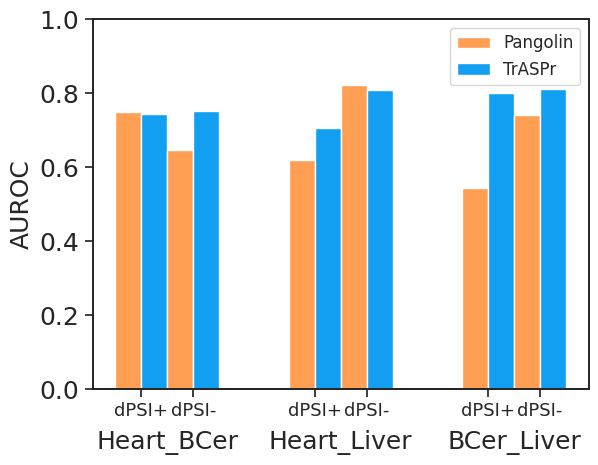

In [78]:
sns.set(font_scale = 1)
x = list(range(1,4))
sns.set_style(style='white')
width = 0.15
n = 15
color = plt.get_cmap('rainbow', n) #2 6 7
fig, ax = plt.subplots()
# ax.bar(np.array(x)-0.15, efficiency, width = 0.3, color=cmap(norm(0)), label = 'Success%')
ax.bar(np.array(x)-width/2*3, pangolin_auc_dpsi_plus, width=width, color=color(11), label = 'Pangolin')
ax.bar(np.array(x)-width/2, traspr_auc_dpsi_plus, width=width, color=color(3), label = 'TrASPr')
# ax.set_ylabel('dPSI+ AUPRC', fontsize=16)
ax.set_ylabel('AUROC', fontsize=18)
ax.set_ylim(0,1)
sec = ax.secondary_xaxis(location=0)
sec_x = [x-width for x in range(1,4)] + [x+width for x in range(1,4)]
sec.set_xticks(sec_x, labels=['dPSI+']*3 + ['dPSI-']*3, fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=18)

ax2 = ax.twinx()
# ax2.bar(np.array(x)+0.15, max_dpsi, width = 0.3, color=cmap(norm(3)), label = 'Max dPSI') 
ax.bar(np.array(x)+width/2, pangolin_auc_dpsi_minus, width=width, color=color(11))
ax.bar(np.array(x)+width/2*3, traspr_auc_dpsi_minus, width=width, color=color(3))
# ax2.set_ylabel('dPSI- AUPRC', fontsize=16)
# ax2.set_ylim(0,1)
ax2.get_yaxis().set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=18)

plt.xticks(x, ['\nHeart_BCer', '\nHeart_Liver', '\nBCer_Liver'])
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0, prop={'size': 12})

plt.savefig(output_dir + 'dpsiAUROC_compare_pangolin.svg', format="svg",bbox_inches="tight")
plt.show()

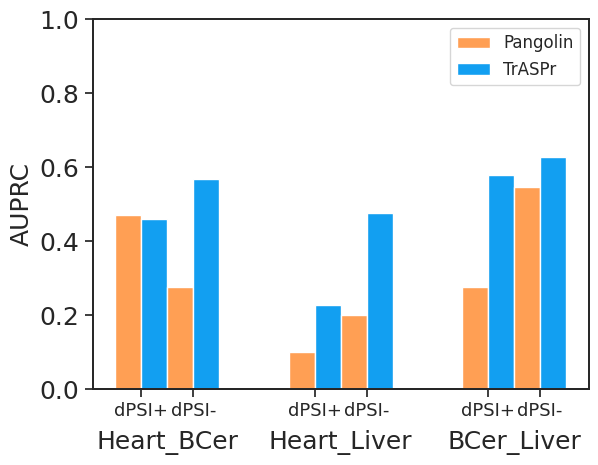

In [77]:
sns.set(font_scale = 1)
x = list(range(1,4))
sns.set_style(style='white')
# c_map = "Set3"
# cmap = plt.cm.get_cmap(c_map)
# norm = colors.Normalize(vmin=1, vmax=12)
width = 0.15
n = 15
color = plt.get_cmap('rainbow', n) #2 6 7
# for i in range(n):
#    c = next(color)
#    plt.plot(x, y, c=c)
pangolin_plus = []

fig, ax = plt.subplots()
# ax.bar(np.array(x)-0.15, efficiency, width = 0.3, color=cmap(norm(0)), label = 'Success%')
ax.bar(np.array(x)-width/2*3, pangolin_prc_dpsi_plus, width=width, color=color(11), label = 'Pangolin')
ax.bar(np.array(x)-width/2, traspr_prc_dpsi_plus, width=width, color=color(3), label = 'TrASPr')
# ax.set_ylabel('dPSI+ AUPRC', fontsize=16)
ax.set_ylabel('AUPRC', fontsize=18)
ax.set_ylim(0,1)
sec = ax.secondary_xaxis(location=0)
sec_x = [x-width for x in range(1,4)] + [x+width for x in range(1,4)]
sec.set_xticks(sec_x, labels=['dPSI+']*3 + ['dPSI-']*3, fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=18)

ax2 = ax.twinx()
# ax2.bar(np.array(x)+0.15, max_dpsi, width = 0.3, color=cmap(norm(3)), label = 'Max dPSI') 
ax.bar(np.array(x)+width/2, pangolin_prc_dpsi_minus, width=width, color=color(11))
ax.bar(np.array(x)+width/2*3, traspr_prc_dpsi_minus, width=width, color=color(3))
# ax2.set_ylabel('dPSI- AUPRC', fontsize=16)
# ax2.set_ylim(0,1)
ax2.get_yaxis().set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=18)

plt.xticks(x, ['\nHeart_BCer', '\nHeart_Liver', '\nBCer_Liver'])
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0, prop={'size': 12})

plt.savefig(output_dir + 'dpsiAUPRC_compare_pangolin.svg', format="svg",bbox_inches="tight")

plt.show()

## Fig3. New tissue learning and alternative splice sites

### a. Heatmaps for ENCODE dataset with/without RBP-AE representation. 

total: 14249
offset percentage: 0.12113130746017264 1726 14249
Spearman: 0.413
Pearson: 0.821


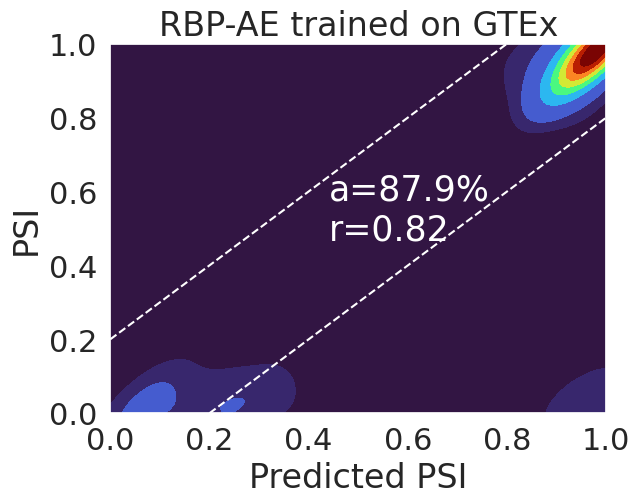

In [10]:
sns.set(font_scale = 2)
POS_THRESHOLD_ABS = 0.15
NEG_THRESHOLD_ABS = 0.05
suffix = 'all'
data_dir = "./data/ENCODE_data_RBPAE.tsv"

data = pd.read_csv(data_dir, sep='\t', header=0)

labels = data["Label"].values
preds = data["AE_pred"].values


total = len(labels)
print("total:", total)

spearman_score = round(spearmanr(labels, preds)[0],3)
pearson_score = round(pearsonr(labels, preds)[0],3)
offset_perc = check_offset_perc(preds, labels)
print("Spearman:",spearman_score)
print("Pearson:",pearson_score)



vmax = 40

ax = sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0)
norm = Normalize(0, vmax)
for collection in ax.collections:
    collection.set_norm(norm)

plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.44,0.47,"a=" + '{:.1f}'.format(round(1-offset_perc, 3)*100) + "%\nr=" + str(pearson_score)[:4], c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('Predicted PSI')
plt.ylabel('PSI')
plt.title('RBP-AE trained on GTEx')
plt.savefig('{}TrASPr_PSI_encode_pokedex_{}_heatmap_train_gtex.svg'.format(output_dir, suffix), dpi=200, format="svg", bbox_inches="tight")
plt.show()

total: 14249
offset percentage: 0.1774159590146677 2528 14249
Spearman: 0.428
Pearson: 0.838


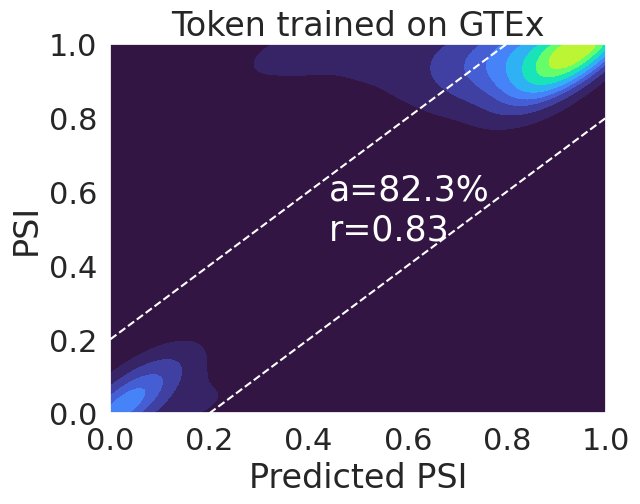

In [14]:
sns.set(font_scale = 2)
POS_THRESHOLD_ABS = 0.15
NEG_THRESHOLD_ABS = 0.05

data_dir = "./data/ENCODE_data_RBPAE.tsv"

data = pd.read_csv(data_dir, sep='\t', header=0)

labels = data["Label"].values
preds = data["TrASPr_pred"].values


total = len(labels)
print("total:", total)

spearman_score = round(spearmanr(labels, preds)[0],3)
pearson_score = round(pearsonr(labels, preds)[0],3)
offset_perc = check_offset_perc(preds, labels)
print("Spearman:",spearman_score)
print("Pearson:",pearson_score)



vmax = 40

ax = sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0)
norm = Normalize(0, vmax)
for collection in ax.collections:
    collection.set_norm(norm)

plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.44,0.47,"a=" + '{:.1f}'.format(round(1-offset_perc, 3)*100) + "%\nr=" + str(pearson_score)[:4], c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('Predicted PSI')
plt.ylabel('PSI')
plt.title('Token trained on GTEx')
plt.savefig('{}TrASPr_PSI_encode_token_{}_heatmap_train_gtex.svg'.format(output_dir, suffix), dpi=200, format="svg", bbox_inches="tight")
plt.show()

### b. Heatmaps for alternative 3'/5' splice site predictions. To plot 3'/5' splice site results, simply change alt_ss to "3" or "5".

total: 1883
offset percentage: 0.06585236325013277 124 1883
Spearman: 0.682
Pearson: 0.926


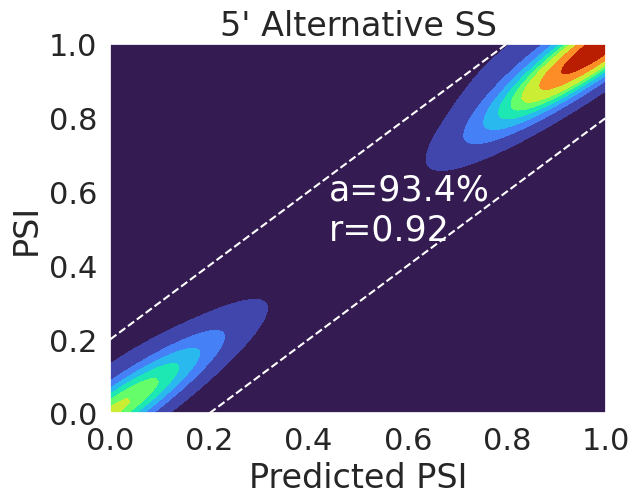

In [16]:
sns.set(font_scale = 2)
POS_THRESHOLD_ABS = 0.15
NEG_THRESHOLD_ABS = 0.05

alt_ss = "5"
data_dir = f"./data/alternative_{alt_ss}.tsv"

if alt_ss == "3":
    norm = Normalize(0, 8.5)
else:
    norm = Normalize(0, 14.2)

data = pd.read_csv(data_dir, sep='\t', header=0)

labels = data["Label"].values
preds = data["TrASPr_pred"].values

total = len(labels)
print("total:", total)

spearman_score = round(spearmanr(labels, preds)[0],3)
pearson_score = round(pearsonr(labels, preds)[0],3)
offset_perc = check_offset_perc(preds, labels)
print("Spearman:",spearman_score)
print("Pearson:",pearson_score)




ax = sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0)
for collection in ax.collections:
    collection.set_norm(norm)

plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.44,0.47,"a=" + '{:.1f}'.format(round(1-offset_perc, 3)*100) + "%\nr=" + str(pearson_score)[:4], c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('Predicted PSI')
plt.ylabel('PSI')
plt.title(f'{alt_ss}\' Alternative SS')
# plt.savefig('{}TrASPr_alt{}_heatmap.svg'.format(figure_dir, alt_ss), dpi=200, format="svg", bbox_inches="tight")
plt.show()

## Fig4. Results for CD19 dataset and RBP knowdown experiments

### a. Swap splice site experiment

38 50


<Axes: xlabel='Category', ylabel='dPSI'>

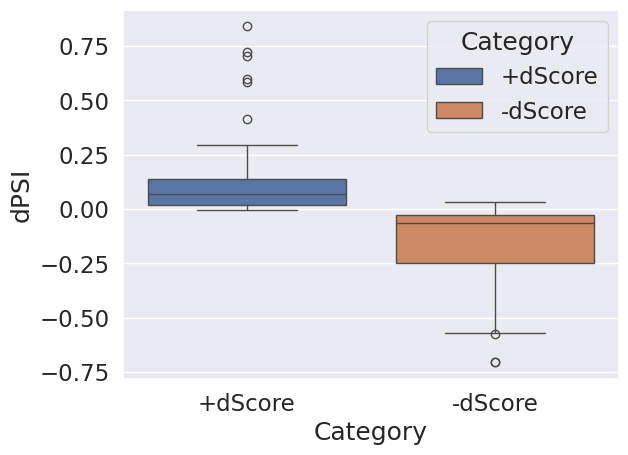

In [ ]:
import seaborn as sns
import pandas as pd

data_dir = "./data/TrASPr_swap_ss_results.tsv"
data = pd.read_csv(data_dir, sep='\t', header=0)

dscores = data["dScores"].values
dpreds = data["TrASPr_pred_dPSI"].values

pos_preds = []
neg_preds = []
sns.set(font_scale = 1.5)

for i in range(len(dscores)):
    if dscores[i] > 0:
        pos_preds.append(dpreds[i])
    else:
        neg_preds.append(dpreds[i])
print(len(pos_preds), len(neg_preds))
df = pd.DataFrame(
    {
        'Category': len(pos_preds) * ["+dScore"] + len(neg_preds) * ["-dScore"],
        'dPSI': pos_preds + neg_preds
    }
)
sns.boxplot(x='Category', y='dPSI', hue='Category', data=df, legend=True)


### b. RBP KD experiments for three models

/tmp/ipykernel_974538/320304009.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(c_map)
/tmp/ipykernel_974538/320304009.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(c_map)
/tmp/ipykernel_974538/320304009.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  edge_cmap = plt.cm.get_cmap("Paired")


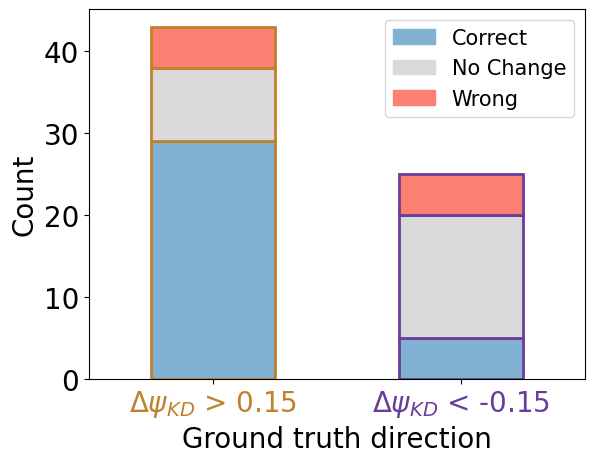

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches
data_dir = "./data/TrASPr_rbpkd_results.tsv"
output_dir = '/home/diwu/project/Ladibug/analysis/figures/'

data = pd.read_csv(data_dir, sep='\t', header=0)

def count_event_nums(key, correct, nochage, wrong):
    correct[0] = len(data[(data["Label_dPSI"]>=0.15) & (data[key]>=PRED_POS_THRESHOLD)])
    nochage[0] = len(data[(data["Label_dPSI"]>=0.15) & (abs(data[key])<PRED_POS_THRESHOLD)])
    wrong[0] = len(data[(data["Label_dPSI"]>=0.15) & (data[key]<=-PRED_POS_THRESHOLD)])

    correct[1] = len(data[(data["Label_dPSI"]<=-0.15) & (data[key]<=-PRED_POS_THRESHOLD)])
    nochage[1] = len(data[(data["Label_dPSI"]<=-0.15) & (abs(data[key])<PRED_POS_THRESHOLD)])
    wrong[1] = len(data[(data["Label_dPSI"]<=-0.15) & (data[key]>=PRED_POS_THRESHOLD)])


PRED_POS_THRESHOLD = 0.019
c_map = "BrBG"
cmap = plt.cm.get_cmap(c_map)
light_brown = cmap(0.2)
indices = (
    "$\Delta\psi_{KD}$ > 0.15",
    "$\Delta\psi_{KD}$ < -0.15",
)
correct = [0,0]
nochage = [0,0]
wrong = [0,0]
count_event_nums("TrASPr_pred_dPSI", correct, nochage, wrong)


weight_counts = {
    "Correct": np.array(correct),
    "No Change": np.array(nochage),
    "Wrong": np.array(wrong)
}
c_map = "Set3"
cmap = plt.cm.get_cmap(c_map)
norm = matplotlib.colors.Normalize(vmin=1, vmax=12)
df = pd.DataFrame(weight_counts, index=indices)

edge_cmap = plt.cm.get_cmap("Paired")
edge_norm = matplotlib.colors.Normalize(vmin=1, vmax=12)
ax = df.plot(kind='bar', stacked=True, color=[cmap(norm(5)), cmap(norm(9)), cmap(norm(4))], rot=0, edgecolor=[light_brown, edge_cmap(edge_norm(10))], linewidth=2, fontsize=20)
for xtick, color in zip(ax.get_xticklabels(), [light_brown, edge_cmap(edge_norm(10))]):
    xtick.set_color(color)
plt.legend(handles=[mpatches.Patch(color=cmap(norm(5)), label='Correct'),
            mpatches.Patch(color=cmap(norm(9)), label='No Change'),
            mpatches.Patch(color=cmap(norm(4)), label='Wrong')], prop={'size': 15})
plt.xlabel("Ground truth direction", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.savefig(output_dir + 'KD_dPSI_TrASPr_updown.svg', dpi=300, format="svg", bbox_inches="tight")

/tmp/ipykernel_974538/2913973293.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(c_map)
/tmp/ipykernel_974538/2913973293.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(c_map)
/tmp/ipykernel_974538/2913973293.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  edge_cmap = plt.cm.get_cmap("Paired")


{'Correct': array([1, 4]), 'No Change': array([34, 20]), 'Wrong': array([8, 1])}


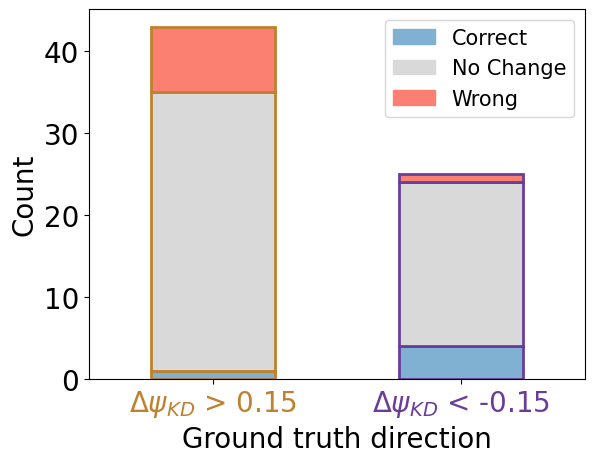

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches
data_dir = "./data/TrASPr_rbpkd_results.tsv"
data = pd.read_csv(data_dir, sep='\t', header=0)

PRED_POS_THRESHOLD = 0.019
c_map = "BrBG"
cmap = plt.cm.get_cmap(c_map)
light_brown = cmap(0.2)
indices = (
    "$\Delta\psi_{KD}$ > 0.15",
    "$\Delta\psi_{KD}$ < -0.15",
)
correct = [0,0]
nochage = [0,0]
wrong = [0,0]
count_event_nums("Pangolin_pred_dPSI", correct, nochage, wrong)

weight_counts = {
    "Correct": np.array(correct),
    "No Change": np.array(nochage),
    "Wrong": np.array(wrong)
}
print(weight_counts)
c_map = "Set3"
cmap = plt.cm.get_cmap(c_map)
norm = matplotlib.colors.Normalize(vmin=1, vmax=12)
df = pd.DataFrame(weight_counts, index=indices)

edge_cmap = plt.cm.get_cmap("Paired")
edge_norm = matplotlib.colors.Normalize(vmin=1, vmax=12)
ax = df.plot(kind='bar', stacked=True, color=[cmap(norm(5)), cmap(norm(9)), cmap(norm(4))], rot=0, edgecolor=[light_brown, edge_cmap(edge_norm(10))], linewidth=2, fontsize=20)
for xtick, color in zip(ax.get_xticklabels(), [light_brown, edge_cmap(edge_norm(10))]):
    xtick.set_color(color)
plt.legend(handles=[mpatches.Patch(color=cmap(norm(5)), label='Correct'),
            mpatches.Patch(color=cmap(norm(9)), label='No Change'),
            mpatches.Patch(color=cmap(norm(4)), label='Wrong')], prop={'size': 15})
plt.xlabel("Ground truth direction", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.savefig(output_dir + 'KD_dPSI_pangolin_updown.svg', dpi=300, format="svg", bbox_inches="tight")

/tmp/ipykernel_974538/2137844832.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(c_map)
/tmp/ipykernel_974538/2137844832.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(c_map)
/tmp/ipykernel_974538/2137844832.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  edge_cmap = plt.cm.get_cmap("Paired")


{'Correct': array([1, 3]), 'No Change': array([31, 22]), 'Wrong': array([11,  0])}


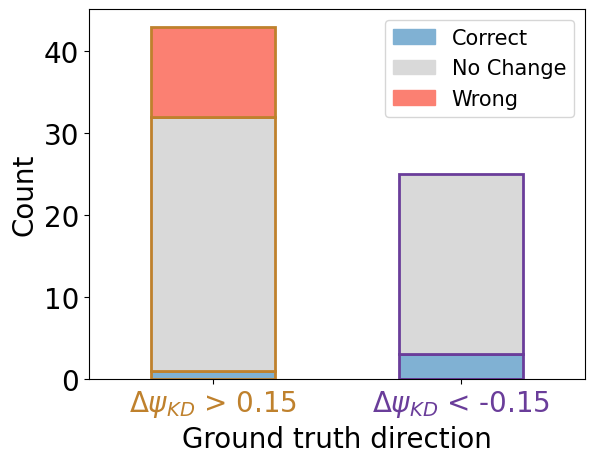

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches
data_dir = "./data/TrASPr_rbpkd_results.tsv"
data = pd.read_csv(data_dir, sep='\t', header=0)

PRED_POS_THRESHOLD = 0.019
c_map = "BrBG"
cmap = plt.cm.get_cmap(c_map)
light_brown = cmap(0.2)
indices = (
    "$\Delta\psi_{KD}$ > 0.15",
    "$\Delta\psi_{KD}$ < -0.15",
)
correct = [0,0]
nochage = [0,0]
wrong = [0,0]
count_event_nums("SpliceAI_pred_dPSI", correct, nochage, wrong)

weight_counts = {
    "Correct": np.array(correct),
    "No Change": np.array(nochage),
    "Wrong": np.array(wrong)
}
print(weight_counts)
c_map = "Set3"
cmap = plt.cm.get_cmap(c_map)
norm = matplotlib.colors.Normalize(vmin=1, vmax=12)
df = pd.DataFrame(weight_counts, index=indices)

edge_cmap = plt.cm.get_cmap("Paired")
edge_norm = matplotlib.colors.Normalize(vmin=1, vmax=12)
ax = df.plot(kind='bar', stacked=True, color=[cmap(norm(5)), cmap(norm(9)), cmap(norm(4))], rot=0, edgecolor=[light_brown, edge_cmap(edge_norm(10))], linewidth=2, fontsize=20)
for xtick, color in zip(ax.get_xticklabels(), [light_brown, edge_cmap(edge_norm(10))]):
    xtick.set_color(color)
plt.legend(handles=[mpatches.Patch(color=cmap(norm(5)), label='Correct'),
            mpatches.Patch(color=cmap(norm(9)), label='No Change'),
            mpatches.Patch(color=cmap(norm(4)), label='Wrong')], prop={'size': 15})
plt.xlabel("Ground truth direction", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.savefig(output_dir + 'KD_dPSI_spliceAI_updown.svg', dpi=300, format="svg", bbox_inches="tight")

### c,d. CD19 experiments

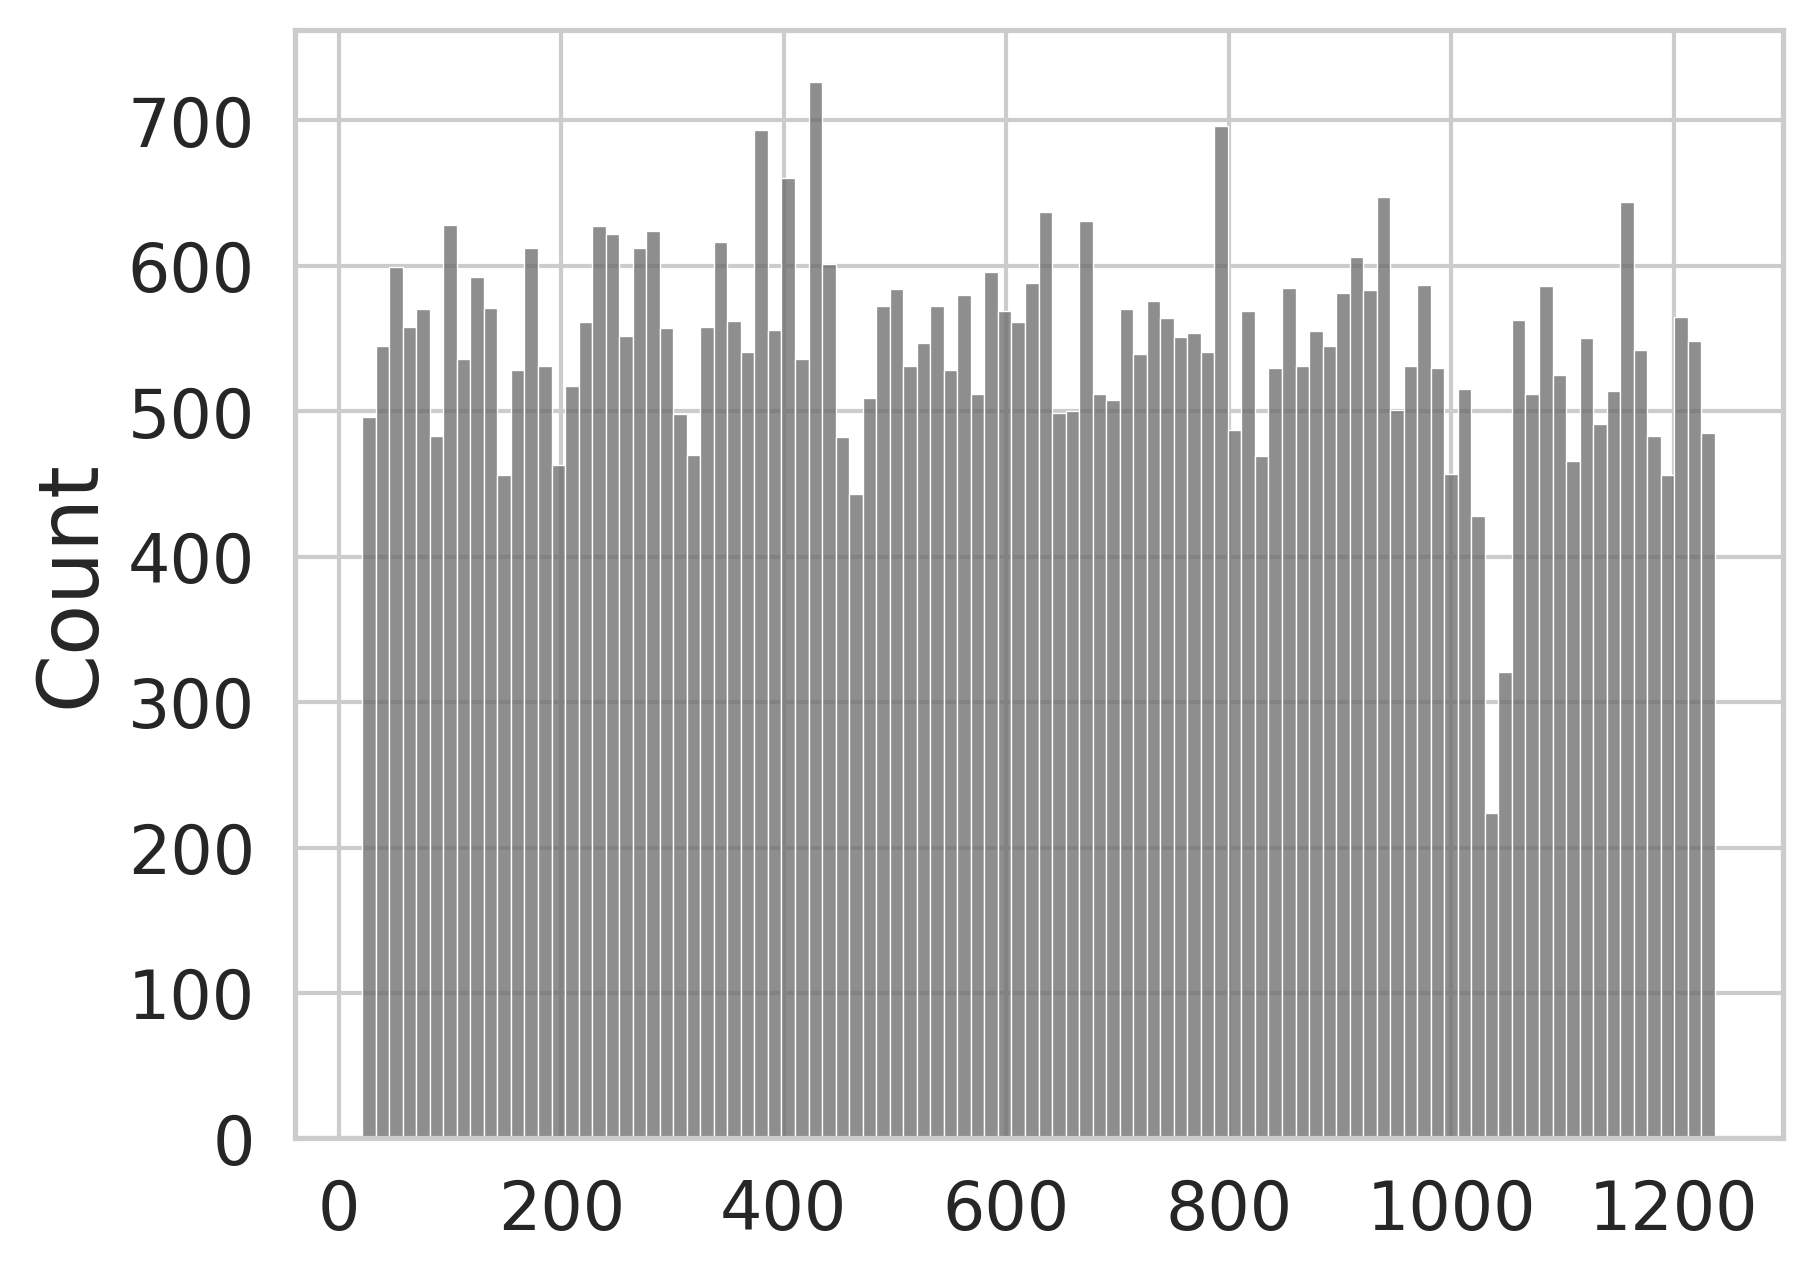

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

index_file = "./data/CD19_mutation_pos.txt"

data = []
sns.set(font_scale = 2)
with open(index_file) as f:
    next(f)
    for line in f:
        line = line.strip().split('\t')
        if line[0] == 'WT':
            continue
        indices = [int(x) for x in line[1].split(' ')]
        
        data.extend(indices)

sns.set_style('whitegrid')
ax = sns.histplot(data, stat="count",bins=100, color="dimgrey")
ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
plt.ylabel('Count', fontsize = 20)
plt.show()

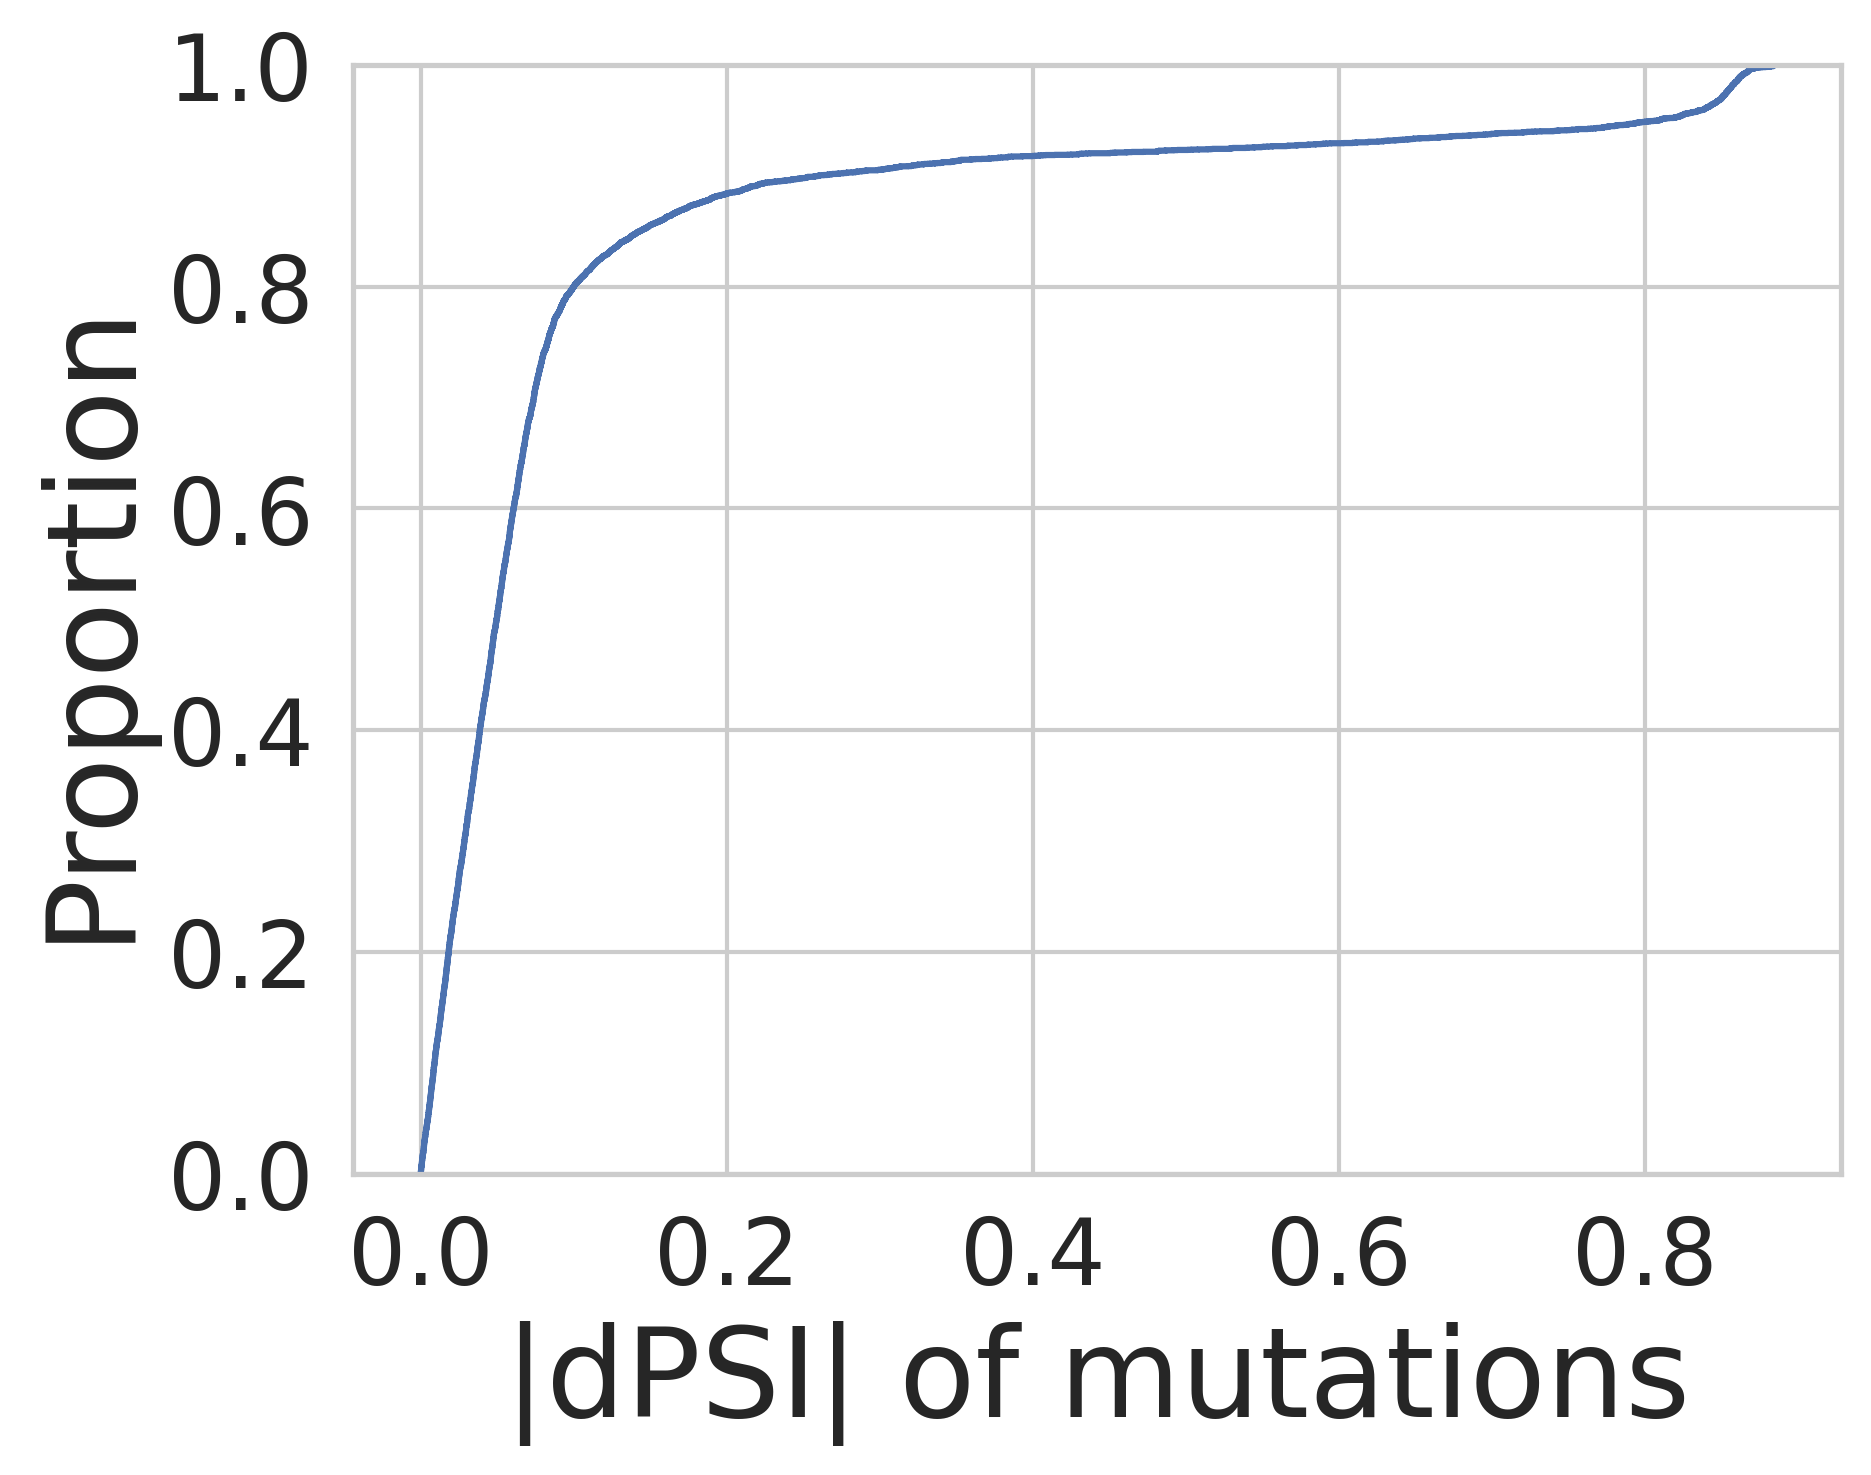

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches
data_dir = "./data/CD19_crossVal.tsv"
data = pd.read_csv(data_dir, sep='\t', header=0)

psis = data[data["Index"] != "WT"]["Label"].values
wt_psi = data[data["Index"] == "WT"]["Label"].values

sns.set(font_scale = 2)
sns.set_style('whitegrid')

dpsis = abs(np.array(psis) - wt_psi)
sns.ecdfplot(dpsis)
plt.xlabel("|dPSI| of mutations", fontsize = 30)
plt.ylabel("Proportion", fontsize = 30)


plt.show()

#### Cross validation results

offset percentage: 0.03652743652743653 223 6105
0.9291861313233163


Text(0, 0.5, 'PSI')

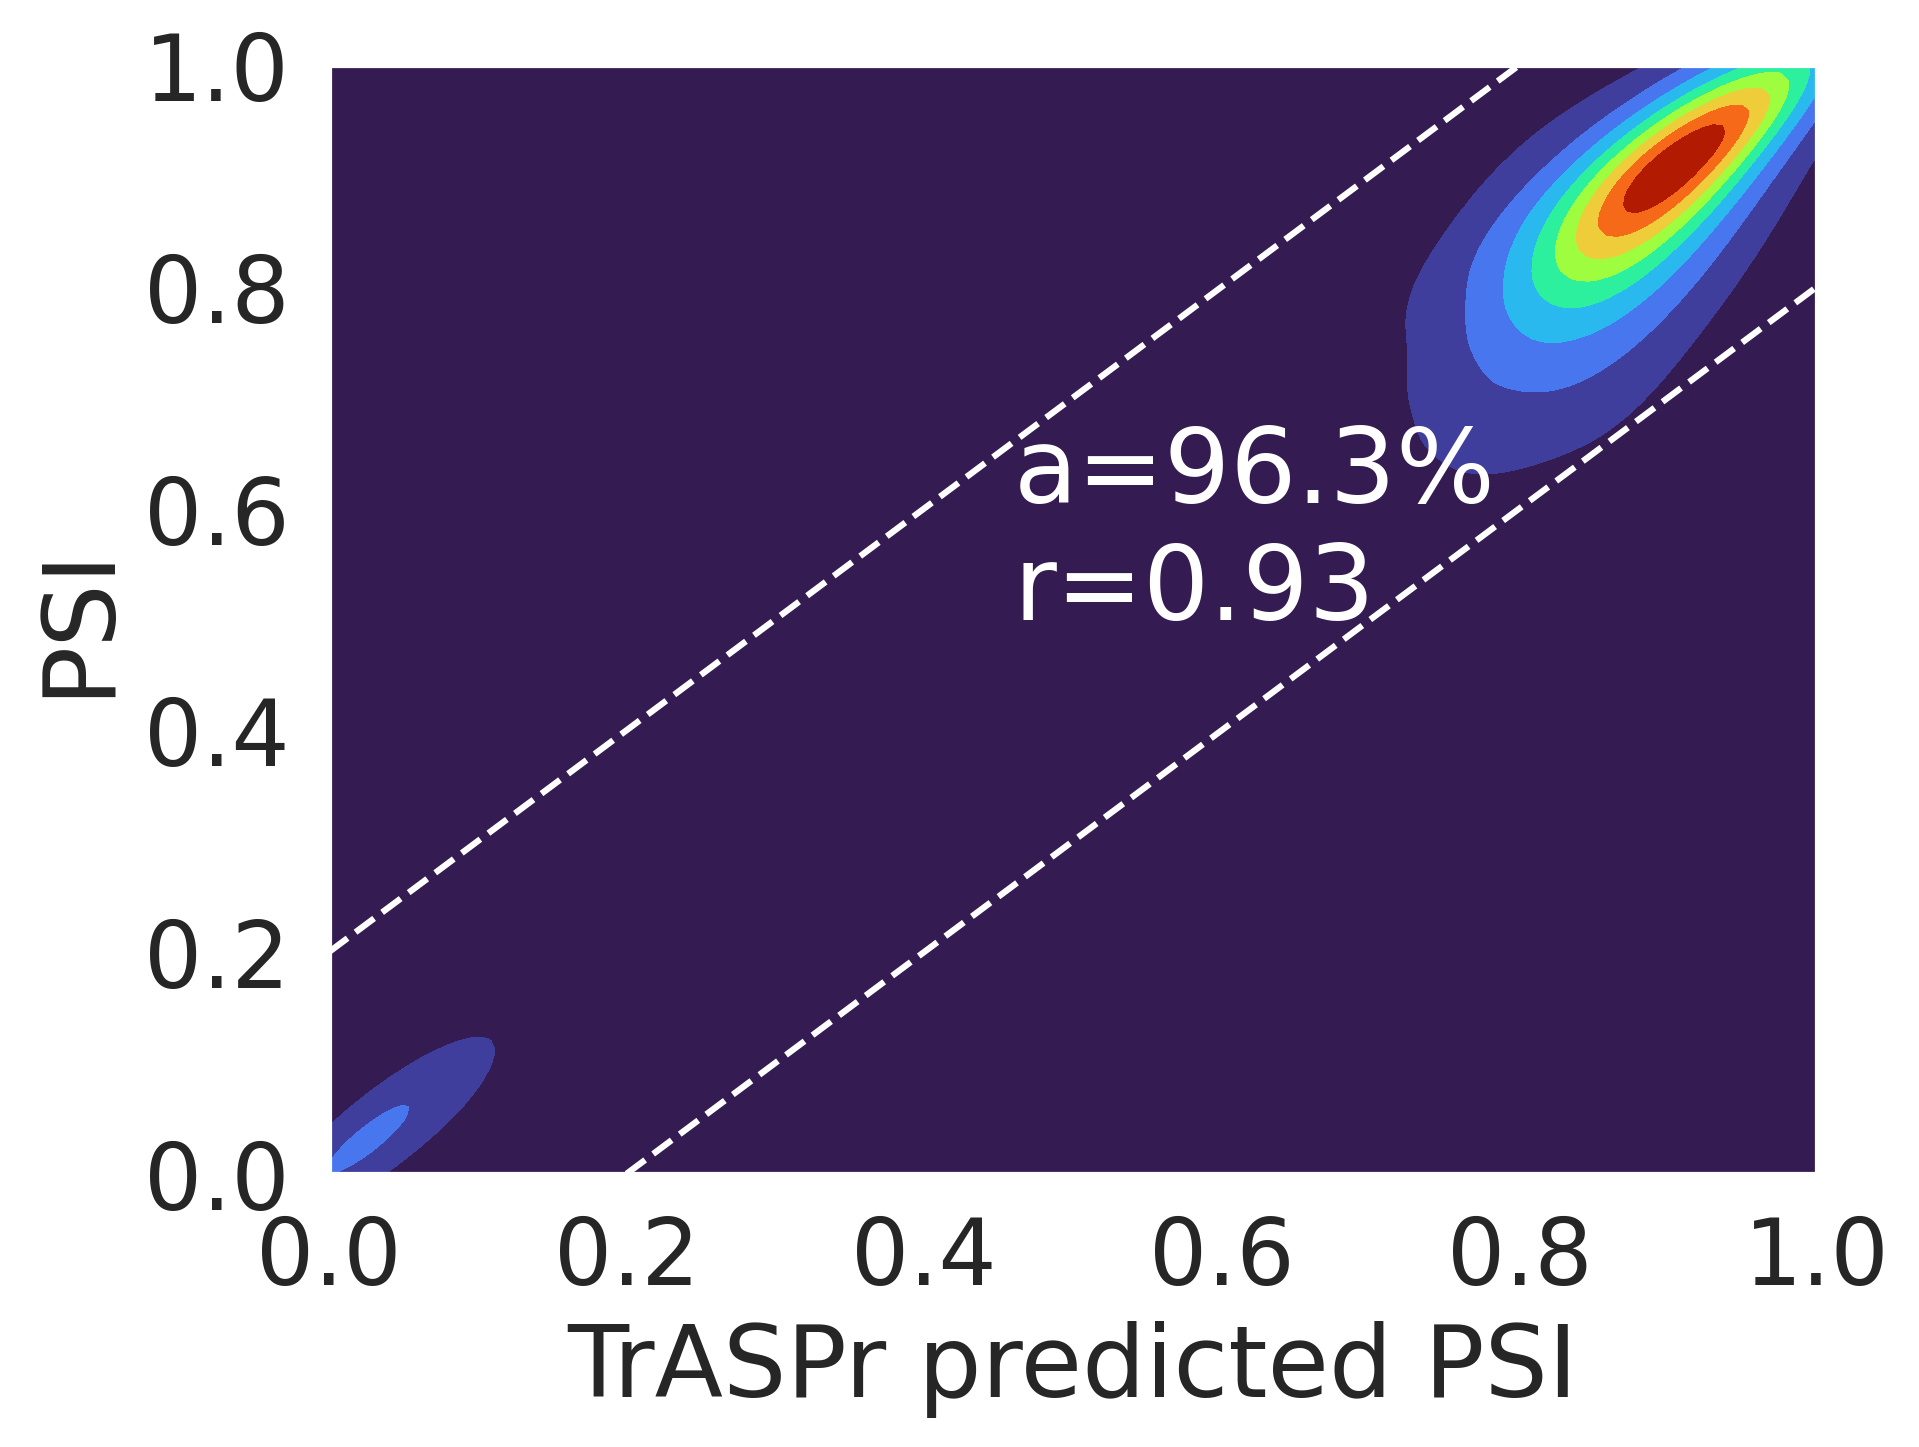

In [24]:
# cross validation results
data_dir = "./data/CD19_crossVal.tsv"
figure_dir = "/home/diwu/project/Ladibug/analysis/figures/"

data = pd.read_csv(data_dir, sep='\t', header=0)

plot_chg = False
sns.set(rc={'figure.figsize':(6.4,4.8)})

if plot_chg == False:
    labels = data[data["Index"] != "WT"]["Label"].values
    preds = data[data["Index"] != "WT"]["TrASPr_pred"].values
else:
    chg_data = data[data["Change_case"]]
    labels = chg_data[chg_data["Index"] != "WT"]["Label"].values
    preds = chg_data[chg_data["Index"] != "WT"]["TrASPr_pred"].values

sns.set_theme(font_scale = 2)
pearson_score, _ = pearsonr(labels, preds)
offset_perc = check_offset_perc(preds, labels)
print(pearson_score)
# tmp = preds[0]
# preds[0] = 0.1


ax=sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0, cbar_kws = {"location":"bottom", "format":"%.1f"})
# preds[0] = tmp


plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.46,0.5,"a={:.1f}".format((1-offset_perc)*100) + "%\nr={:.2f}".format(pearson_score), c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('TrASPr predicted PSI')
plt.ylabel('PSI')


offset percentage: 0.6428571428571429 567 882
0.4636027243943745


Text(0, 0.5, 'PSI')

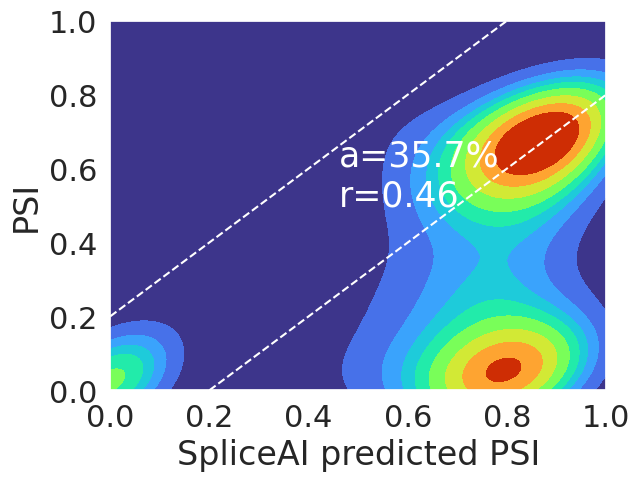

In [20]:
data_dir = "./data/CD19_crossVal.tsv"
data = pd.read_csv(data_dir, sep='\t', header=0)

plot_chg = True


if plot_chg == False:
    labels = data[data["Index"] != "WT"]["Label"].values
    preds = data[data["Index"] != "WT"]["SpliceAI_pred"].values
else:
    chg_data = data[data["Change_case"]]
    labels = chg_data[chg_data["Index"] != "WT"]["Label"].values
    preds = chg_data[chg_data["Index"] != "WT"]["SpliceAI_pred"].values

sns.set_theme(font_scale = 2)
pearson_score, _ = pearsonr(labels, preds)
offset_perc = check_offset_perc(preds, labels)
print(pearson_score)
# tmp = preds[0]
# preds[0] = 0.1
ax=sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0, cbar_kws = {"location":"bottom", "format":"%.1f"})
# preds[0] = tmp


plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.46,0.5,"a={:.1f}".format((1-offset_perc)*100) + "%\nr={:.2f}".format(pearson_score), c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('SpliceAI predicted PSI')
plt.ylabel('PSI')

#### Single filtering results

offset percentage: 0.07572684246112238 112 1479
0.9074841715802853


Text(0, 0.5, 'PSI')

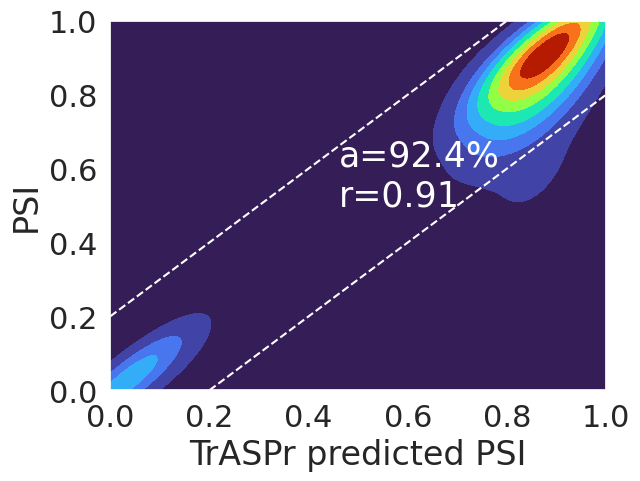

In [16]:
# single filtering results
data_dir = "./data/CD19_single_filter.tsv"
data = pd.read_csv(data_dir, sep='\t', header=0)

labels = data[data["Index"] != "WT"]["Label"].values
preds = data[data["Index"] != "WT"]["TrASPr_pred"].values


sns.set_theme(font_scale = 2)
pearson_score, _ = pearsonr(labels, preds)
offset_perc = check_offset_perc(preds, labels)
print(pearson_score)
tmp = preds[0]
preds[0] = 0.1
ax=sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0, cbar_kws = {"location":"bottom", "format":"%.1f"})
preds[0] = tmp


plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.46,0.5,"a={:.1f}".format((1-offset_perc)*100) + "%\nr={:.2f}".format(pearson_score), c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('TrASPr predicted PSI')
plt.ylabel('PSI')

offset percentage: 0.15415821501014199 228 1479
0.7032256860061443


Text(0, 0.5, 'PSI')

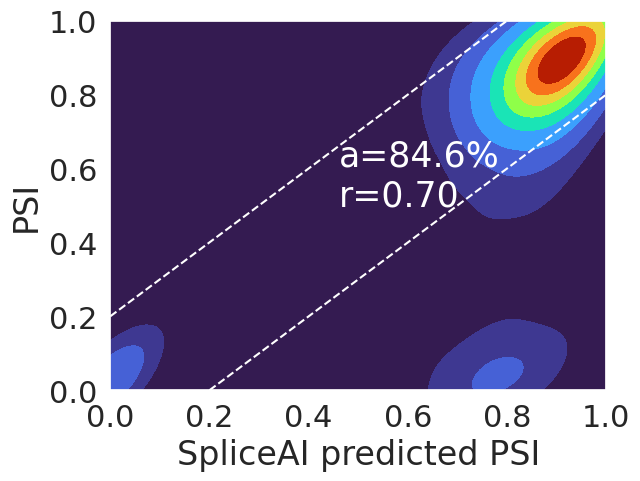

In [19]:
data_dir = "./data/CD19_single_filter.tsv"
data = pd.read_csv(data_dir, sep='\t', header=0)

labels = data[data["Index"] != "WT"]["Label"].values
preds = data[data["Index"] != "WT"]["SpliceAI_pred"].values

sns.set_theme(font_scale = 2)
pearson_score, _ = pearsonr(labels, preds)
offset_perc = check_offset_perc(preds, labels)
print(pearson_score)
tmp = preds[0]
preds[0] = 0.1
ax=sns.kdeplot(x=preds, y=labels, fill=True, cmap='turbo', cbar=False, thresh=0, cbar_kws = {"location":"bottom", "format":"%.1f"})
preds[0] = tmp


plt.plot([0.2,1], [0,0.8], '--', c='w')
plt.plot([0,0.8],[0.2,1], '--', c='w')
plt.text(0.46,0.5,"a={:.1f}".format((1-offset_perc)*100) + "%\nr={:.2f}".format(pearson_score), c='w', fontsize=25)

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('SpliceAI predicted PSI')
plt.ylabel('PSI')

## Fig5. Results for Experimental validations

### a. TrASPr prediction validated by LSV-seq

[Text(0, 0, '48.8%'), Text(0, 0, '53.5%'), Text(0, 0, '55.8%')]

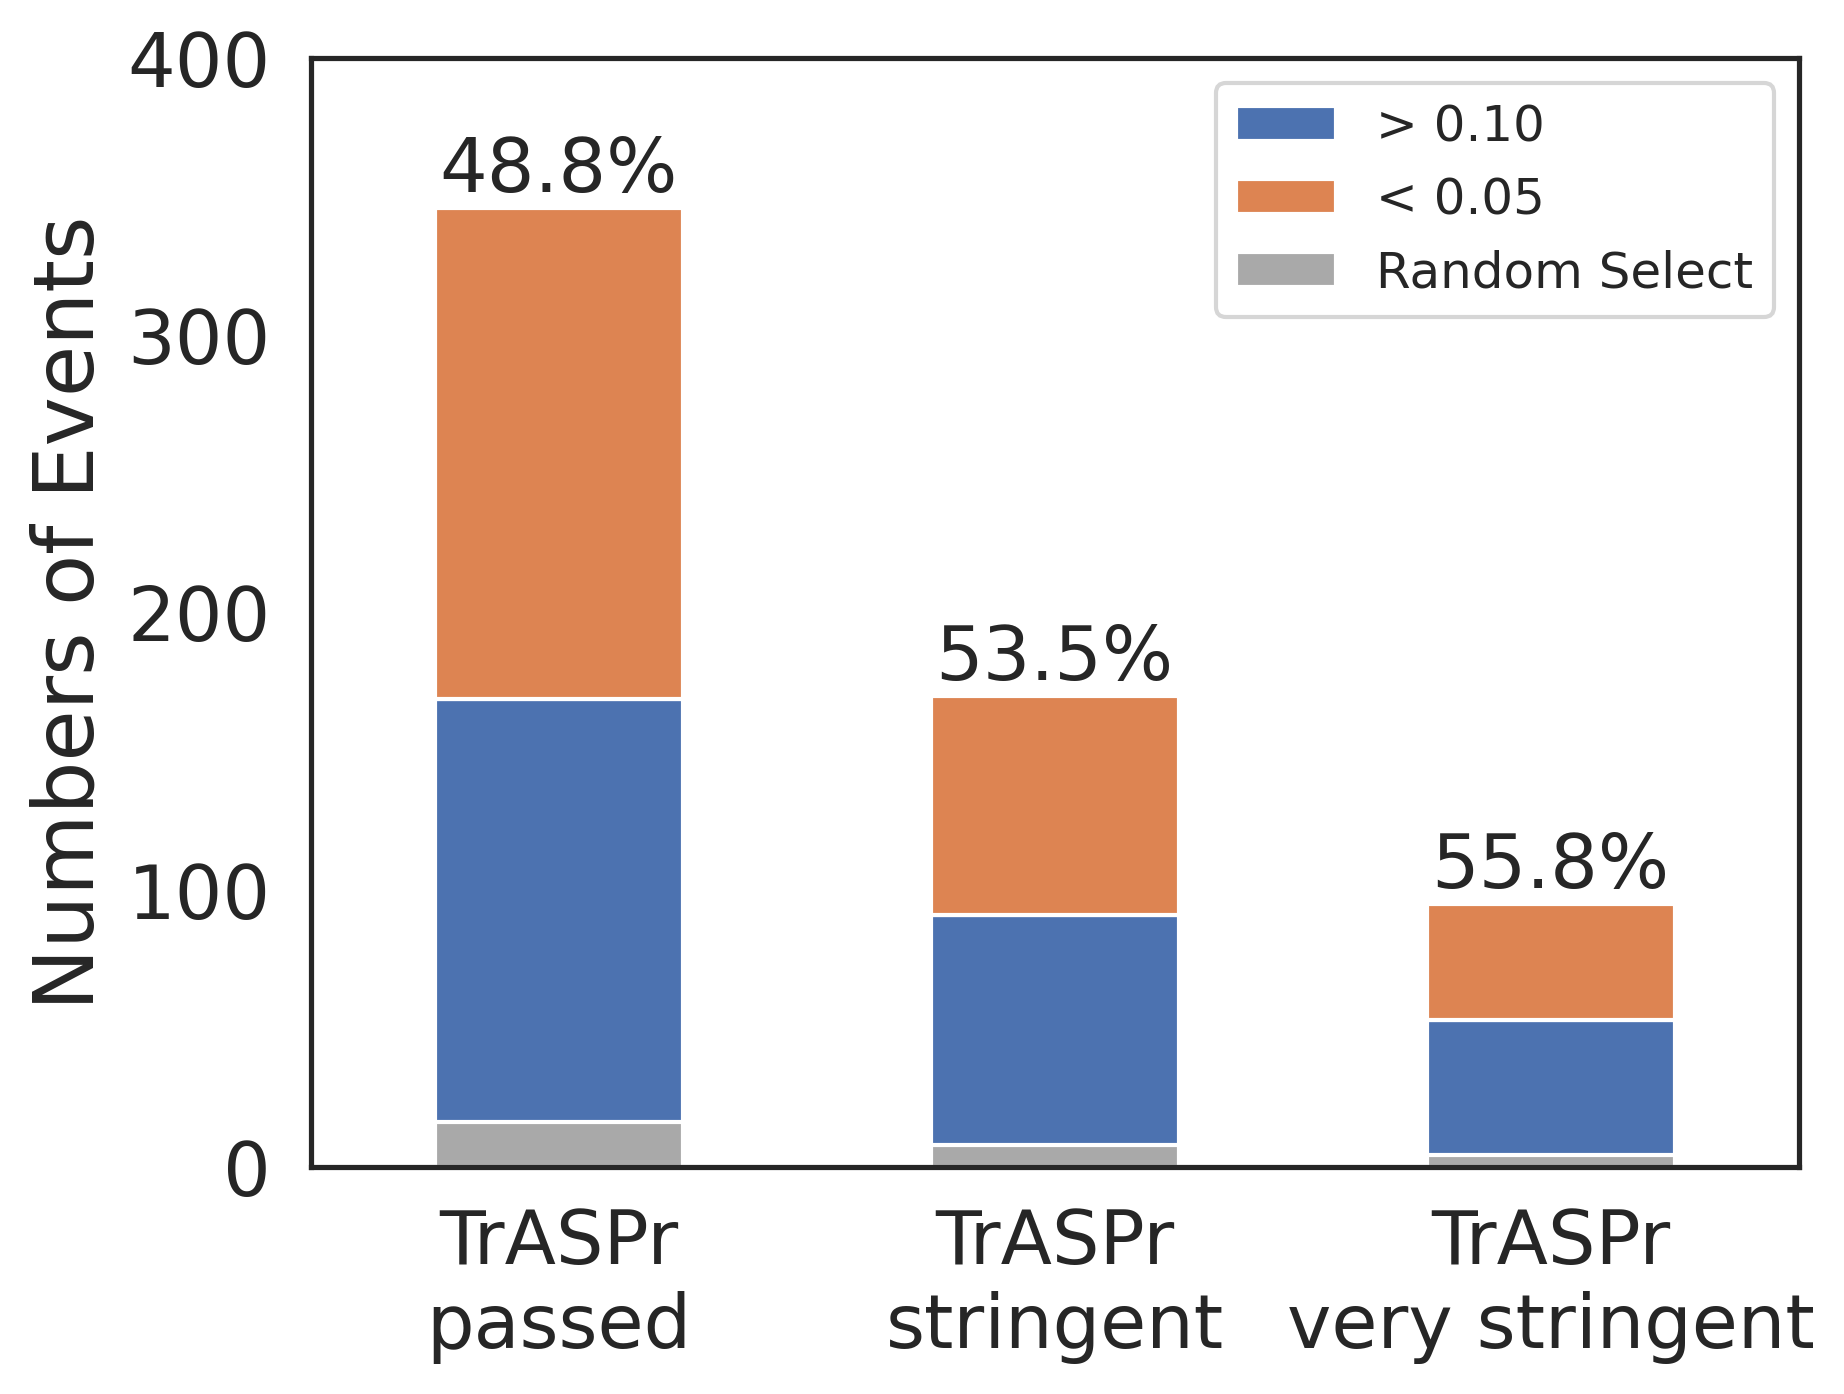

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sns.set_style(style='white')

data_dir = "./data/lsvseq_data.tsv"
data = pd.read_csv(data_dir, sep='\t', header=0)
data = pd.melt(data,id_vars=['change_label'],value_vars=['all_events_overall','splicing_code_passed','splicing_code_passed_stringent','splicing_code_passed_very_stringent'])  #.fillna(False)
data = data[data['value']]

data = data.value_counts(['variable','change_label']).reset_index().pivot(index='variable',columns='change_label',values="count")
data = data[['> 0.10','< 0.05']]
data = data.reindex(['all_events_overall',
              'splicing_code_passed','splicing_code_passed_stringent','splicing_code_passed_very_stringent'])
data.index=['all_events_overall', 'TrASPr\npassed', 'TrASPr\nstringent', 'TrASPr\nvery stringent']

df = data.loc[['TrASPr\npassed', 'TrASPr\nstringent', 'TrASPr\nvery stringent']]
total = df.sum(axis=1)
prop_labels = (df["> 0.10"]/total).round(3) * 100
prop_labels = prop_labels.apply(lambda x:"{:.1f}%".format(x))
x = list(range(3))

ax = df.plot(kind='bar', stacked=True)
sns.barplot(x=x, y=total.values*0.047, width=0.5, color="darkgrey", label="Random Select")
plt.legend(prop={'size': 12})
plt.xticks(x, df.index, fontsize=18, rotation=0)
plt.yticks(fontsize=18)
plt.ylabel("Numbers of Events", fontsize = 20)
plt.ylim(0, 400)

ax.bar_label(ax.containers[1],labels=prop_labels, fontsize=18)

## Fig6. Results for Bayesian Optimization results

### a. BOS for recovering disrupted alternative splice sites. Change variable `ss_type` to 3 or 5 to plot figures for 3' or 5' splice site resutls.

/tmp/ipykernel_974538/2795844366.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(c_map)


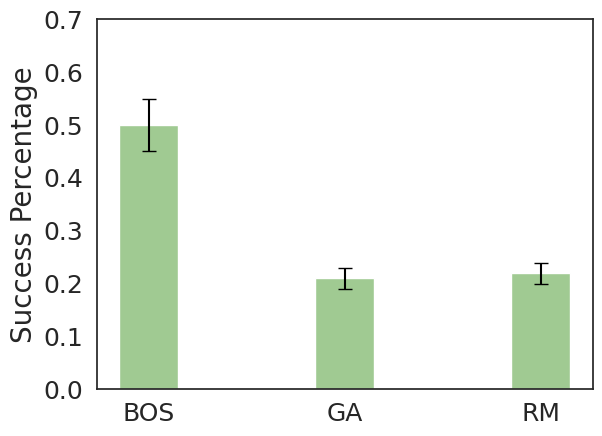

In [30]:
#comparison with strawman algorithms

import seaborn as sns
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

total_gen_num = 10000
ss_type = 3

bos_dir = f"./data/disrupt_ss/{ss_type}ss/BOS/"
rm_dir = f"./data/disrupt_ss/{ss_type}ss/GA/"
ga_dir = f"./data/disrupt_ss/{ss_type}ss/RM/"

efficiency=[[], [], []]
max_dpsis=[[], [], []]


file_list = []
success_num = 0
total_num = 0
max_dpsi = 0
for filename in os.listdir(bos_dir):
    if not filename.endswith(".csv"):
        continue
    with open(bos_dir + filename, "rb") as f:
        num_lines = sum(1 for _ in f)
    efficiency[0].append(num_lines/total_gen_num)

for filename in os.listdir(ga_dir):
    if not filename.endswith(".csv"):
        continue
    with open(ga_dir + filename, "rb") as f:
        num_lines = sum(1 for _ in f)
    efficiency[1].append(num_lines/total_gen_num)
    
for filename in os.listdir(rm_dir):
    if not filename.endswith(".csv"):
        continue
    with open(rm_dir + filename, "rb") as f:
        num_lines = sum(1 for _ in f)
    efficiency[2].append(num_lines/total_gen_num)


x = np.array(range(1,4))

c_map = "Set3"
cmap = plt.cm.get_cmap(c_map)
norm = colors.Normalize(vmin=1, vmax=12)
fig, ax = plt.subplots()

ax.bar(x, np.mean(efficiency, axis=1), width = 0.3, color="#a0ca92", label = 'Success%')
ax.set_ylabel('Success Percentage', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylim(0,0.7)
# ax.boxplot(efficiency, positions=x-0.15)
ax.errorbar(x, np.mean(efficiency, axis=1), yerr=np.std(efficiency, axis=1),capsize=5, ls='none', color='black')


plt.xticks(x, ['BOS', 'GA', 'RM'])
plt.show()

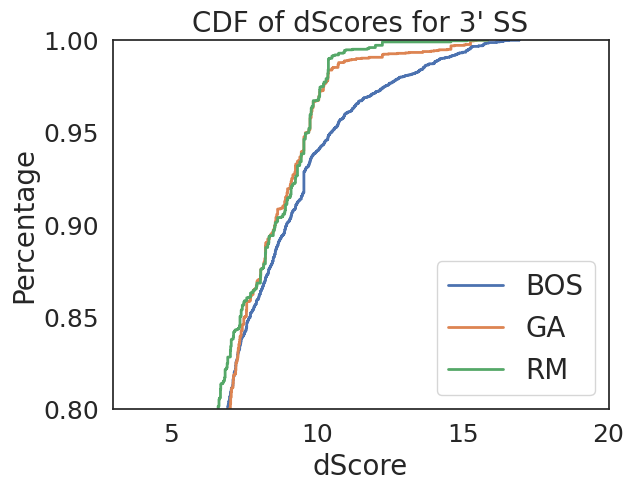

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib, os
import numpy as np


ss_type = 3

score_file = "mutate_ss_seq.score"
id_file = "mutate_ss_seq_ids.output"

def get_dscore(data_dir):
    scores = []
    dscores = []
    with open(data_dir+id_file) as f_id, open(data_dir+score_file) as f_score:
        seq_dscore = {}
        wt_scores = []
        for line in f_id:
            if not line.startswith(">"):
                if seq_dscore:
                    wt_score = sorted(wt_scores, reverse=True)[1]+1
                    for seq_id in seq_dscore:
                        dscores.append(max(seq_dscore[seq_id]) - wt_score)
                        scores.append(max(seq_dscore[seq_id]))
                    seq_dscore = {}
                    wt_scores = []
                continue
            seq_id = line.split('\t')[0].split('_')[-1]
            dpsi = float(line.split('\t')[2])
            score = float(next(f_score).split('\t')[1])

            if seq_id == "wt":
                wt_scores.append(score)
            else:
                if seq_id not in seq_dscore:
                    seq_dscore[seq_id] = [score]
                else:
                    seq_dscore[seq_id].append(score)
        wt_score = sorted(wt_scores, reverse=True)[0]
        for seq_id in seq_dscore:
            dscores.append(max(seq_dscore[seq_id]) - wt_score)
            scores.append(max(seq_dscore[seq_id]))
    return dscores

bos_dir = f"./data/disrupt_ss/{ss_type}ss/BOS/"
rm_dir = f"./data/disrupt_ss/{ss_type}ss/GA/"
ga_dir = f"./data/disrupt_ss/{ss_type}ss/RM/"

dscores = get_dscore(bos_dir)
sns.ecdfplot(dscores, label='BOS', linewidth = 2)

dscores = get_dscore(ga_dir)
sns.ecdfplot(dscores, label='GA', linewidth = 2)

dscores = get_dscore(rm_dir)
sns.ecdfplot(dscores, label='RM', linewidth = 2)


plt.title(f'CDF of dScores for {ss_type}\' SS', fontsize = 20)
plt.xlabel('dScore', fontsize = 20)
plt.ylabel('Percentage', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(np.arange(0.8,1.1,0.05),fontsize=18)
plt.xlim(3,20)
plt.ylim(0.8,1)
plt.legend(fontsize=20, loc="lower right")
# plt.savefig("{}BOS_recover_ss_{}_CDF_comparison.svg".format(output_dir, ss_type), format="svg", bbox_inches="tight")

### b. Distribution of BOS hits for CD19 dataset

Text(0, 0.5, 'Percentage')

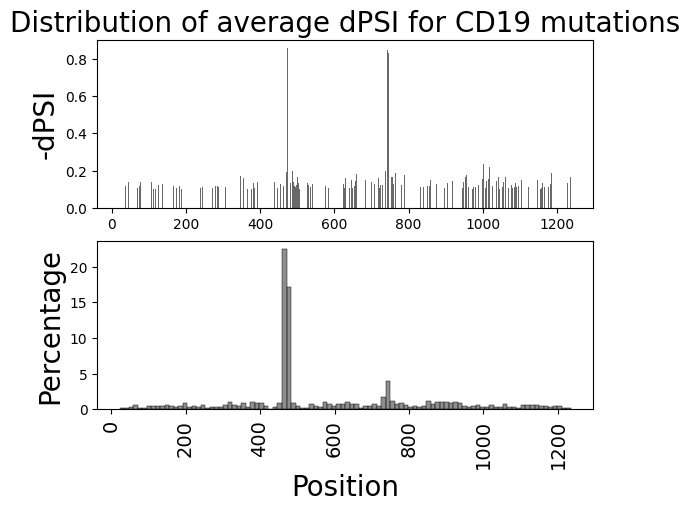

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.reset_orig
index_file = "./data/CD19_mutation_pos.txt"
label_file = "./data/CD19_crossVal.tsv"
bos_pos_file = "./data/BOS_results_edit_index_CD19.txt"

output_dir = '/home/diwu/project/Ladibug/analysis/figures/'
start_end_coord = [130, 219, 475, 743, 1040, 1225] # start/end of exons
ss_pos = [219, 475, 743, 1040]
region_names = {'E1I1':0, 'I1A':1, 'AI2':2, 'I2E2':3}

def convert_ind_cd19(pos_list, region, seq_len):
    result = []
    ss_ind = ss_pos[region_names[region]]
    mid = seq_len//2
    for pos in pos_list:
        result.append(ss_ind + pos - mid)
    return result


index_label = {}
pos_psi = {}
tmp = []
count = 0
with open(index_file) as f:
    for line in f:
        line = line.strip().split('\t')
        ids = line[0]
        if ids == 'WT':
            continue
        
        indices = [int(x) for x in line[1].split(' ')]
        index_label[ids] = [indices, 0]

with open(label_file) as f:
    next(f)
    for line in f:
        line = line.strip().split('\t')
        ids = line[0]
        psi = float(line[2])
        if ids == "WT":
            wt_psi = psi
            continue
        index_label[ids][1] = psi

for ids in index_label:
    indices, psi = index_label[ids]
    for ind in indices:
        if ind not in pos_psi:
            pos_psi[ind] = [psi]
        else:
            pos_psi[ind].append(psi)

pos = []
dpsis = []

for ind in pos_psi:
    if len(pos_psi[ind]) < 10:
        continue
    dpsi = wt_psi - np.mean(pos_psi[ind])        
    if abs(dpsi) < 0.1:
        continue
    pos.append(int(ind))
    dpsis.append(dpsi)


id_line = None
pos_list = []
bos_pos = []
with open(bos_pos_file) as f:
    for line in f:
        if line.startswith(">"):
            if id_line and not id_line.endswith('wt\n'):
                bos_pos.extend(pos_list)
            id_line = line
            wt_psi, dpsi = [float(x) for x in next(f).strip().split('\t')]
            pos_list = []
        else:
            line = line.strip().split('\t')
            if line[1] == '':
                continue
            # import pdb; pdb.set_trace()
            region = line[0]
            
            seq = line[2]
            seq_len = len(seq)
            
            region_pos = [int(x) for x in line[1].split(' ')]
            pos_list.extend(convert_ind_cd19(region_pos, region, seq_len))
    bos_pos.extend(pos_list)

fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
# plt.rcParams.update({'font.size': 22})
ax1.bar(x=pos, height=dpsis, color="dimgrey")
# ax1.set_title('Distribution of CD19 mutations dPSI and BOS hits', fontsize = 20)
ax1.set_title('Distribution of average dPSI for CD19 mutations', fontsize = 20)
plt.xticks(fontsize=14, rotation=90)
# ax1.set_xlabel('Position', fontsize = 20)
ax1.set_ylabel('-dPSI', fontsize = 20)
sns.histplot(bos_pos, stat="percent",bins=100, color="dimgrey",ax=ax2)
# plt.title('Distribution of hits for BOS', fontsize = 20)
ax2.set_xlabel('Position', fontsize = 20)
ax2.set_ylabel('Percentage', fontsize = 20)

### c. BOS, GA and RM results for generating Brain Cerebellum specific high inclusive sequences

/tmp/ipykernel_1091805/2068161372.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(c_map)


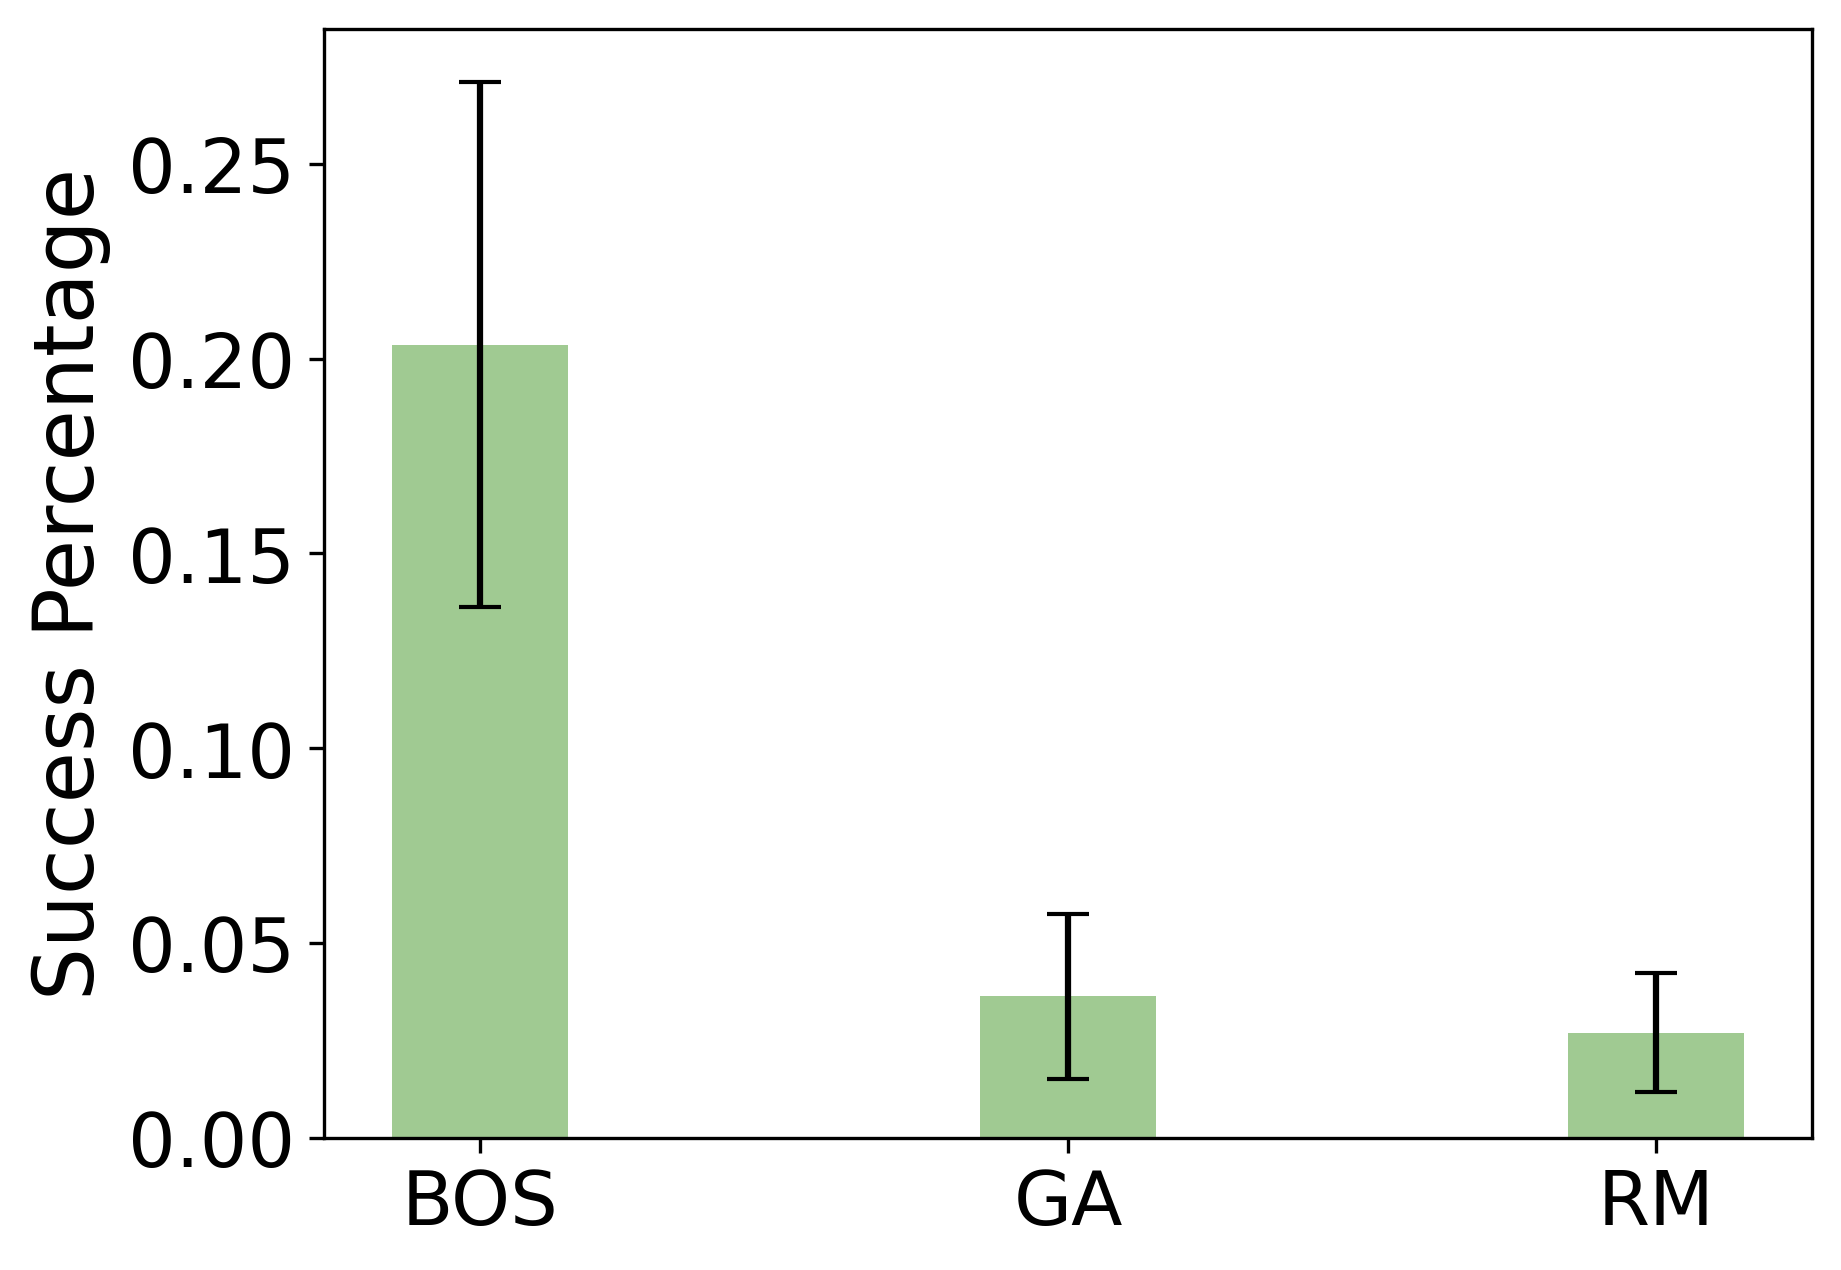

In [5]:
#comparison with strawman algorithms for Brain specific sequences
import os
import seaborn as sns
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
# from mpltools import style
# df = pd.DataFrame({'level_1':[1900, 2014, 2015, 2016, 2017, 2018], 
#                 'total':[0.0, 154.4, 490.9, 628.4,715.2,601.5]})
# style.use('ggplot')
total_gen_num = 10000
data_dir = "./data/brain_specific_10starters/"

efficiency=[[], [], []]




file_list = []
success_num = 0
total_num = 0
max_dpsi = 0
for filename in os.listdir(data_dir):
    if not filename.endswith(".csv"):
        continue
    with open(data_dir + filename, "rb") as f:
        num_lines = sum(1 for _ in f)
    if filename.startswith("bos"):
        efficiency[0].append(num_lines/total_gen_num)
    elif filename.startswith("ga"):
        efficiency[1].append(num_lines/total_gen_num)
    elif filename.startswith("rm"):
        efficiency[2].append(num_lines/total_gen_num)
    else:
        print("Wrong file", filename)

x = np.array(range(1,4))

c_map = "Set3"
cmap = plt.cm.get_cmap(c_map)
norm = colors.Normalize(vmin=1, vmax=12)
fig, ax = plt.subplots()
ax.bar(x, np.mean(efficiency, axis=1), width = 0.3, color="#a0ca92", label = 'Success%')
ax.set_ylabel('Success Percentage', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.errorbar(x, np.mean(efficiency, axis=1), yerr=np.std(efficiency, axis=1),capsize=5, ls='none', color='black')
plt.xticks(x, ['BOS', 'GA', 'RM'])
fig.set_dpi(300)
plt.show()


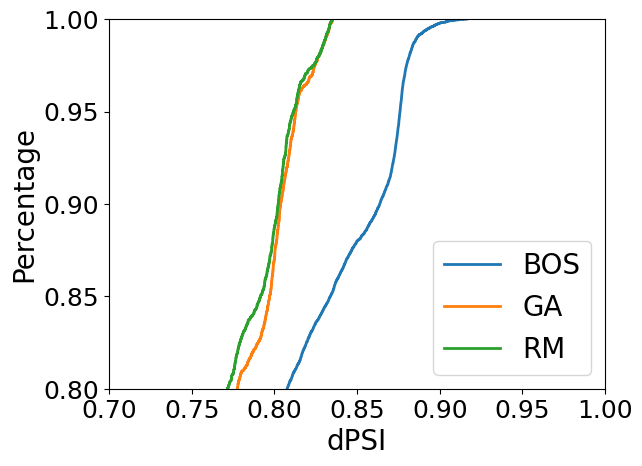

In [6]:

hash_psi = {}
def get_dpsi(filedir):
    ids = '_'.join(filedir.split('/')[-1].split('.')[0].split('_')[1:])
    wt_psi = hash_psi[ids]
    dpsis = []
    with open(filedir) as f:
        next(f)

        for line in f:
            line = line.split(',')
            
            dpsi = abs(float(line[0]) - wt_psi)
            dpsis.append(dpsi)
    return dpsis

with open(data_dir + "all_low_bos_samples.tsv") as f:
    next(f)
    for line in f:
        line = line.strip().split('\t')
        ids = line[0]
        psi = float(line[-1].split(',')[0])
        tissue = line[5]
        hash_psi[ids] = psi

dpsis = []
for filename in os.listdir(data_dir):
    if not filename.endswith(".csv") or not filename.startswith("bos"):
        continue
    dpsis.extend(get_dpsi(data_dir+filename))
sns.ecdfplot(dpsis, label='BOS', linewidth = 2)

dpsis = []
for filename in os.listdir(data_dir):
    if not filename.endswith(".csv") or not filename.startswith("ga"):
        continue
    dpsis.extend(get_dpsi(data_dir+filename))
sns.ecdfplot(dpsis, label='GA', linewidth = 2)

dpsis = []
for filename in os.listdir(data_dir):
    if not filename.endswith(".csv") or not filename.startswith("rm"):
        continue
    dpsis.extend(get_dpsi(data_dir+filename))
sns.ecdfplot(dpsis, label='RM', linewidth = 2)

plt.legend(fontsize=20, loc="lower right")
# plt.title(f'CDF of dPSI', fontsize = 20)
plt.xlabel('dPSI', fontsize = 20)
plt.ylabel('Percentage', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(np.arange(0.8,1.1,0.05), fontsize=18)
plt.xlim(0.7,1)
plt.ylim(0.8,1)
plt.show()

### BOS hits for Daam1 gene on N2A cell line. 

Text(0, 0.5, 'Percentage')

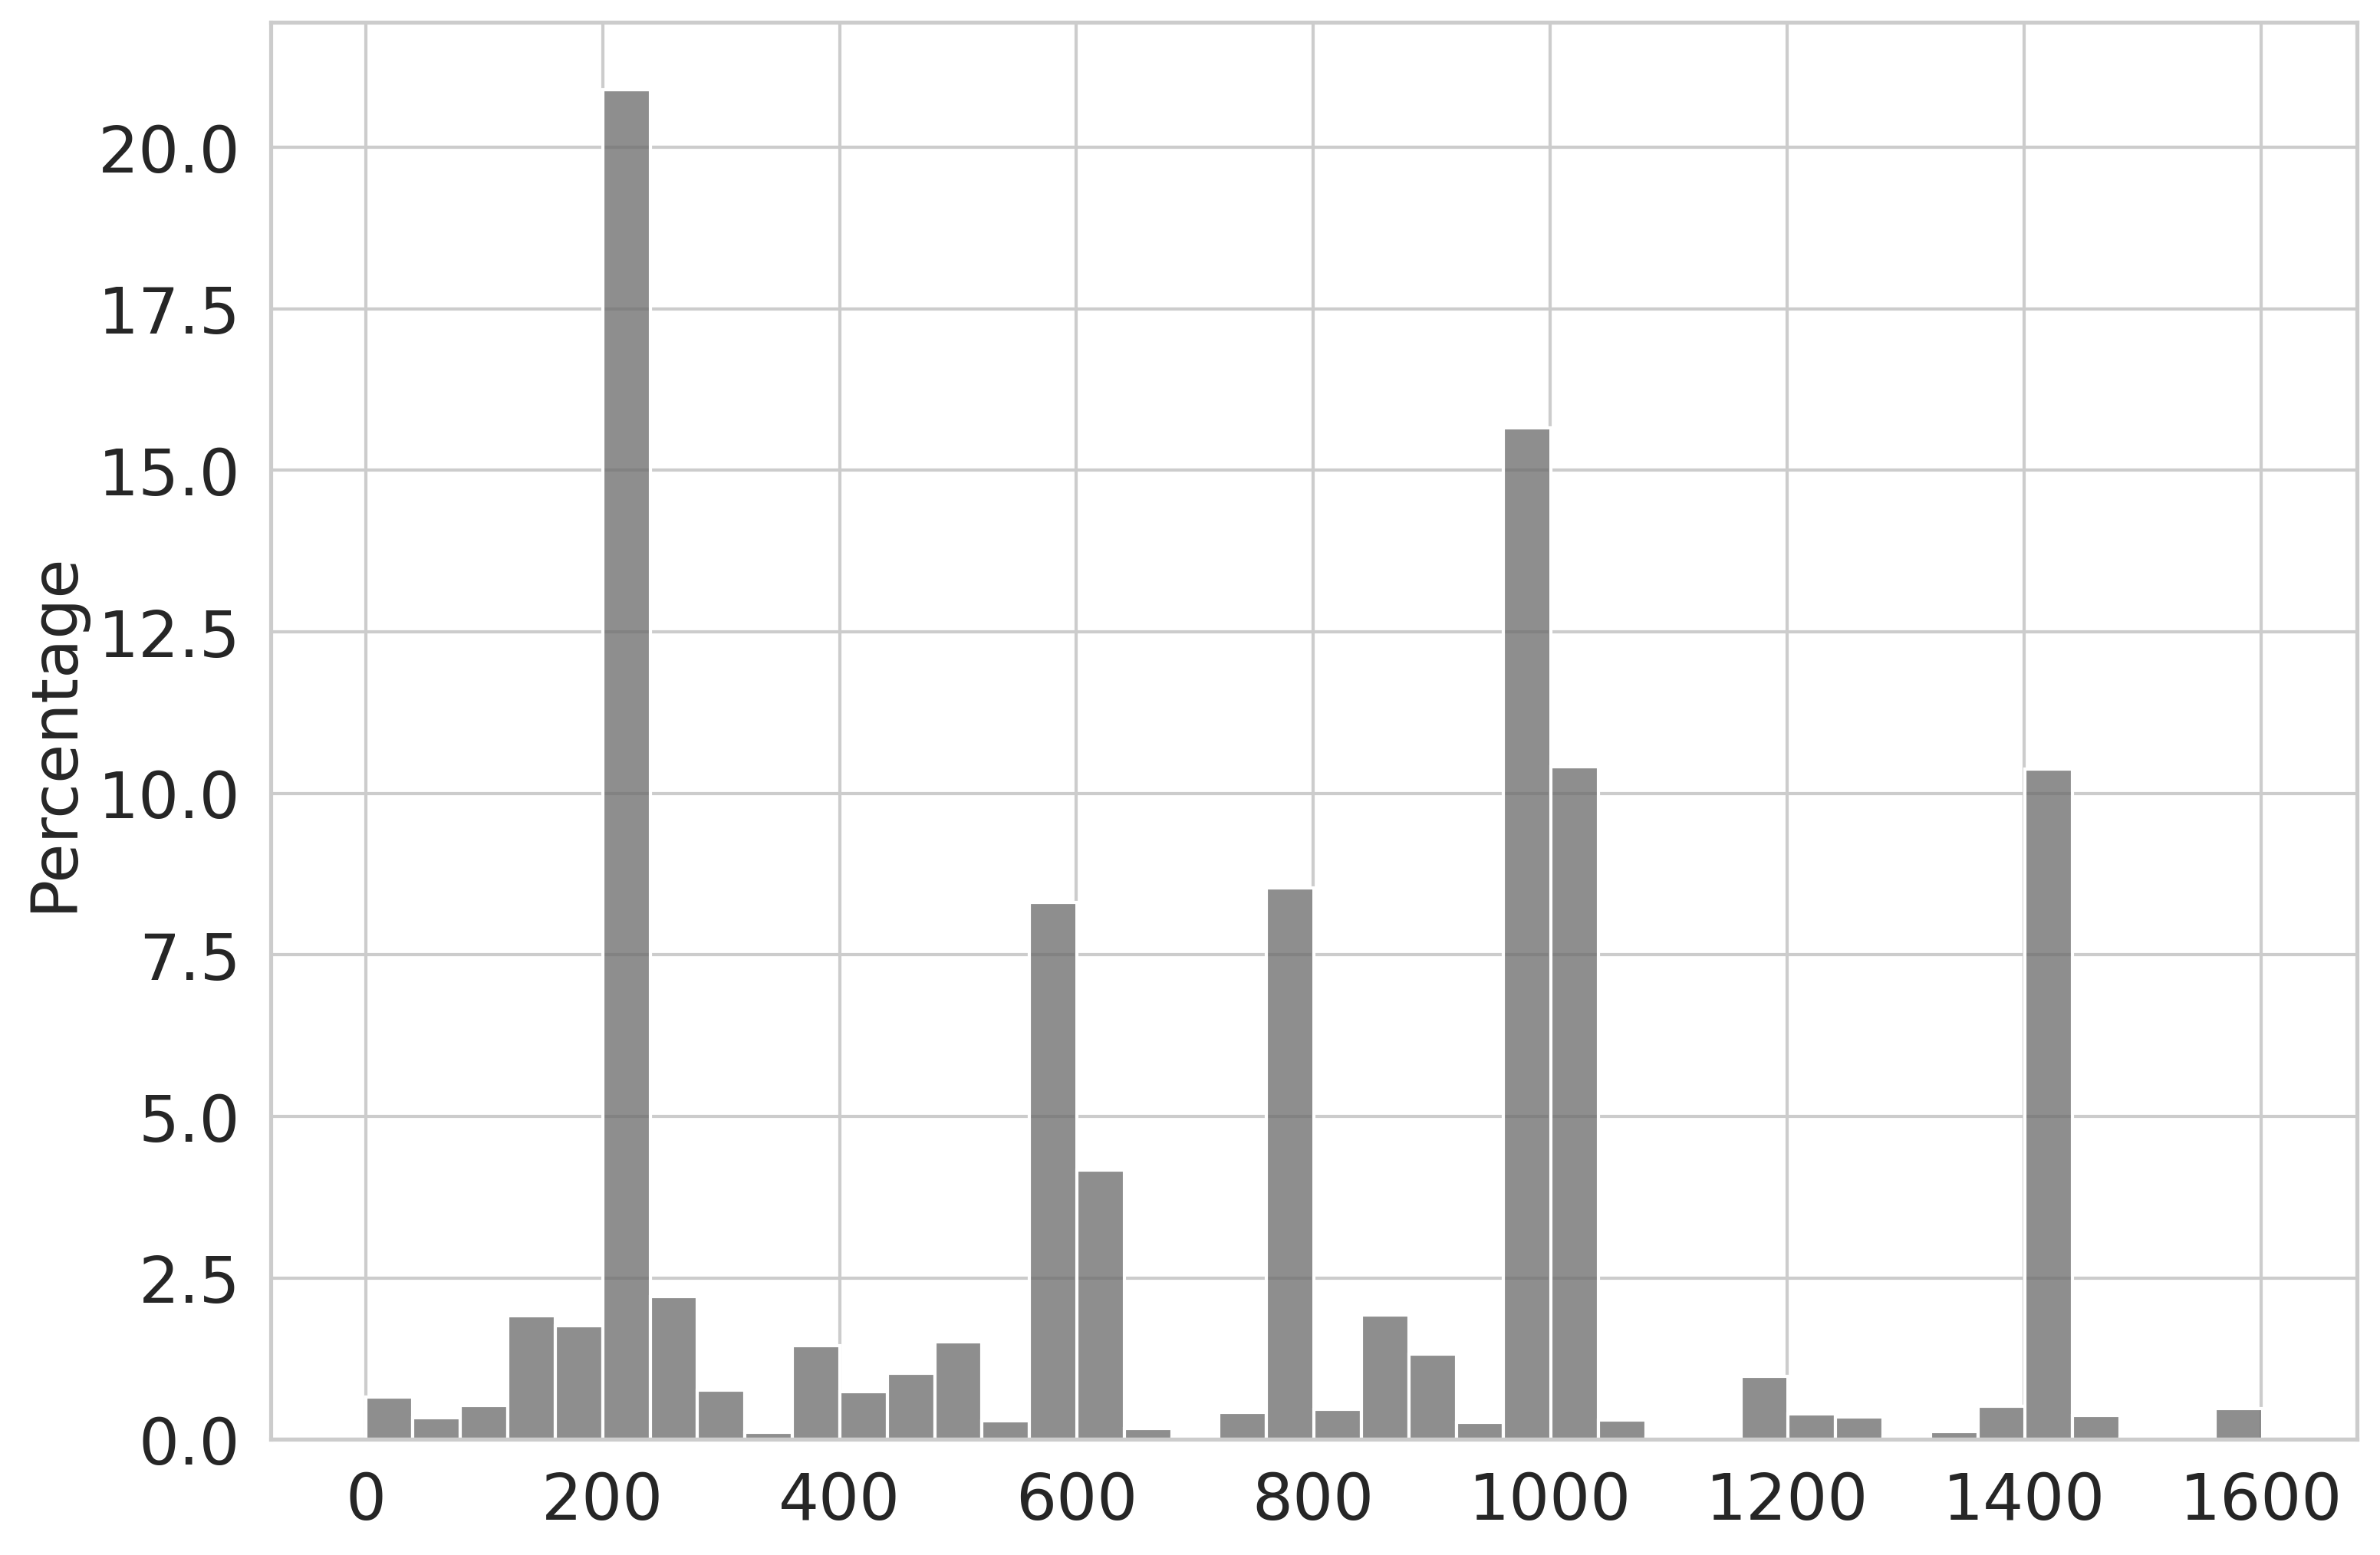

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

index_file = "./data/BOS_Daam1/edit_index_2k.txt"
original_file = "./data/BOS_Daam1/minimize_psi_N2A_daam1_parental_recentered.csv"


data = []
tmp = []
count = 0
with open(index_file) as f, open(original_file) as psi_f:
    next(psi_f)
    psi = float(next(psi_f).split(',')[0])
    for line in f:
        if '>' in line:
            offset = 0
            if tmp:
                data.extend(tmp)
                psi = float(next(psi_f).split(',')[0])
            tmp = []
        else:
            try:
                indices = [int(x)+offset for x in line.strip().split('\t')[1].split(' ')]
            except:
                continue
            tmp.extend(indices)
            offset += 400

            
sns.set(rc={'figure.figsize':(11.7,8), "figure.dpi":300, "figure.dpi":300})
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 20})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
ax = sns.histplot(data, stat="percent",bins=40, color="dimgrey")

plt.ylabel('Percentage', fontsize = 20)


Text(0, 0.5, 'Percentage')

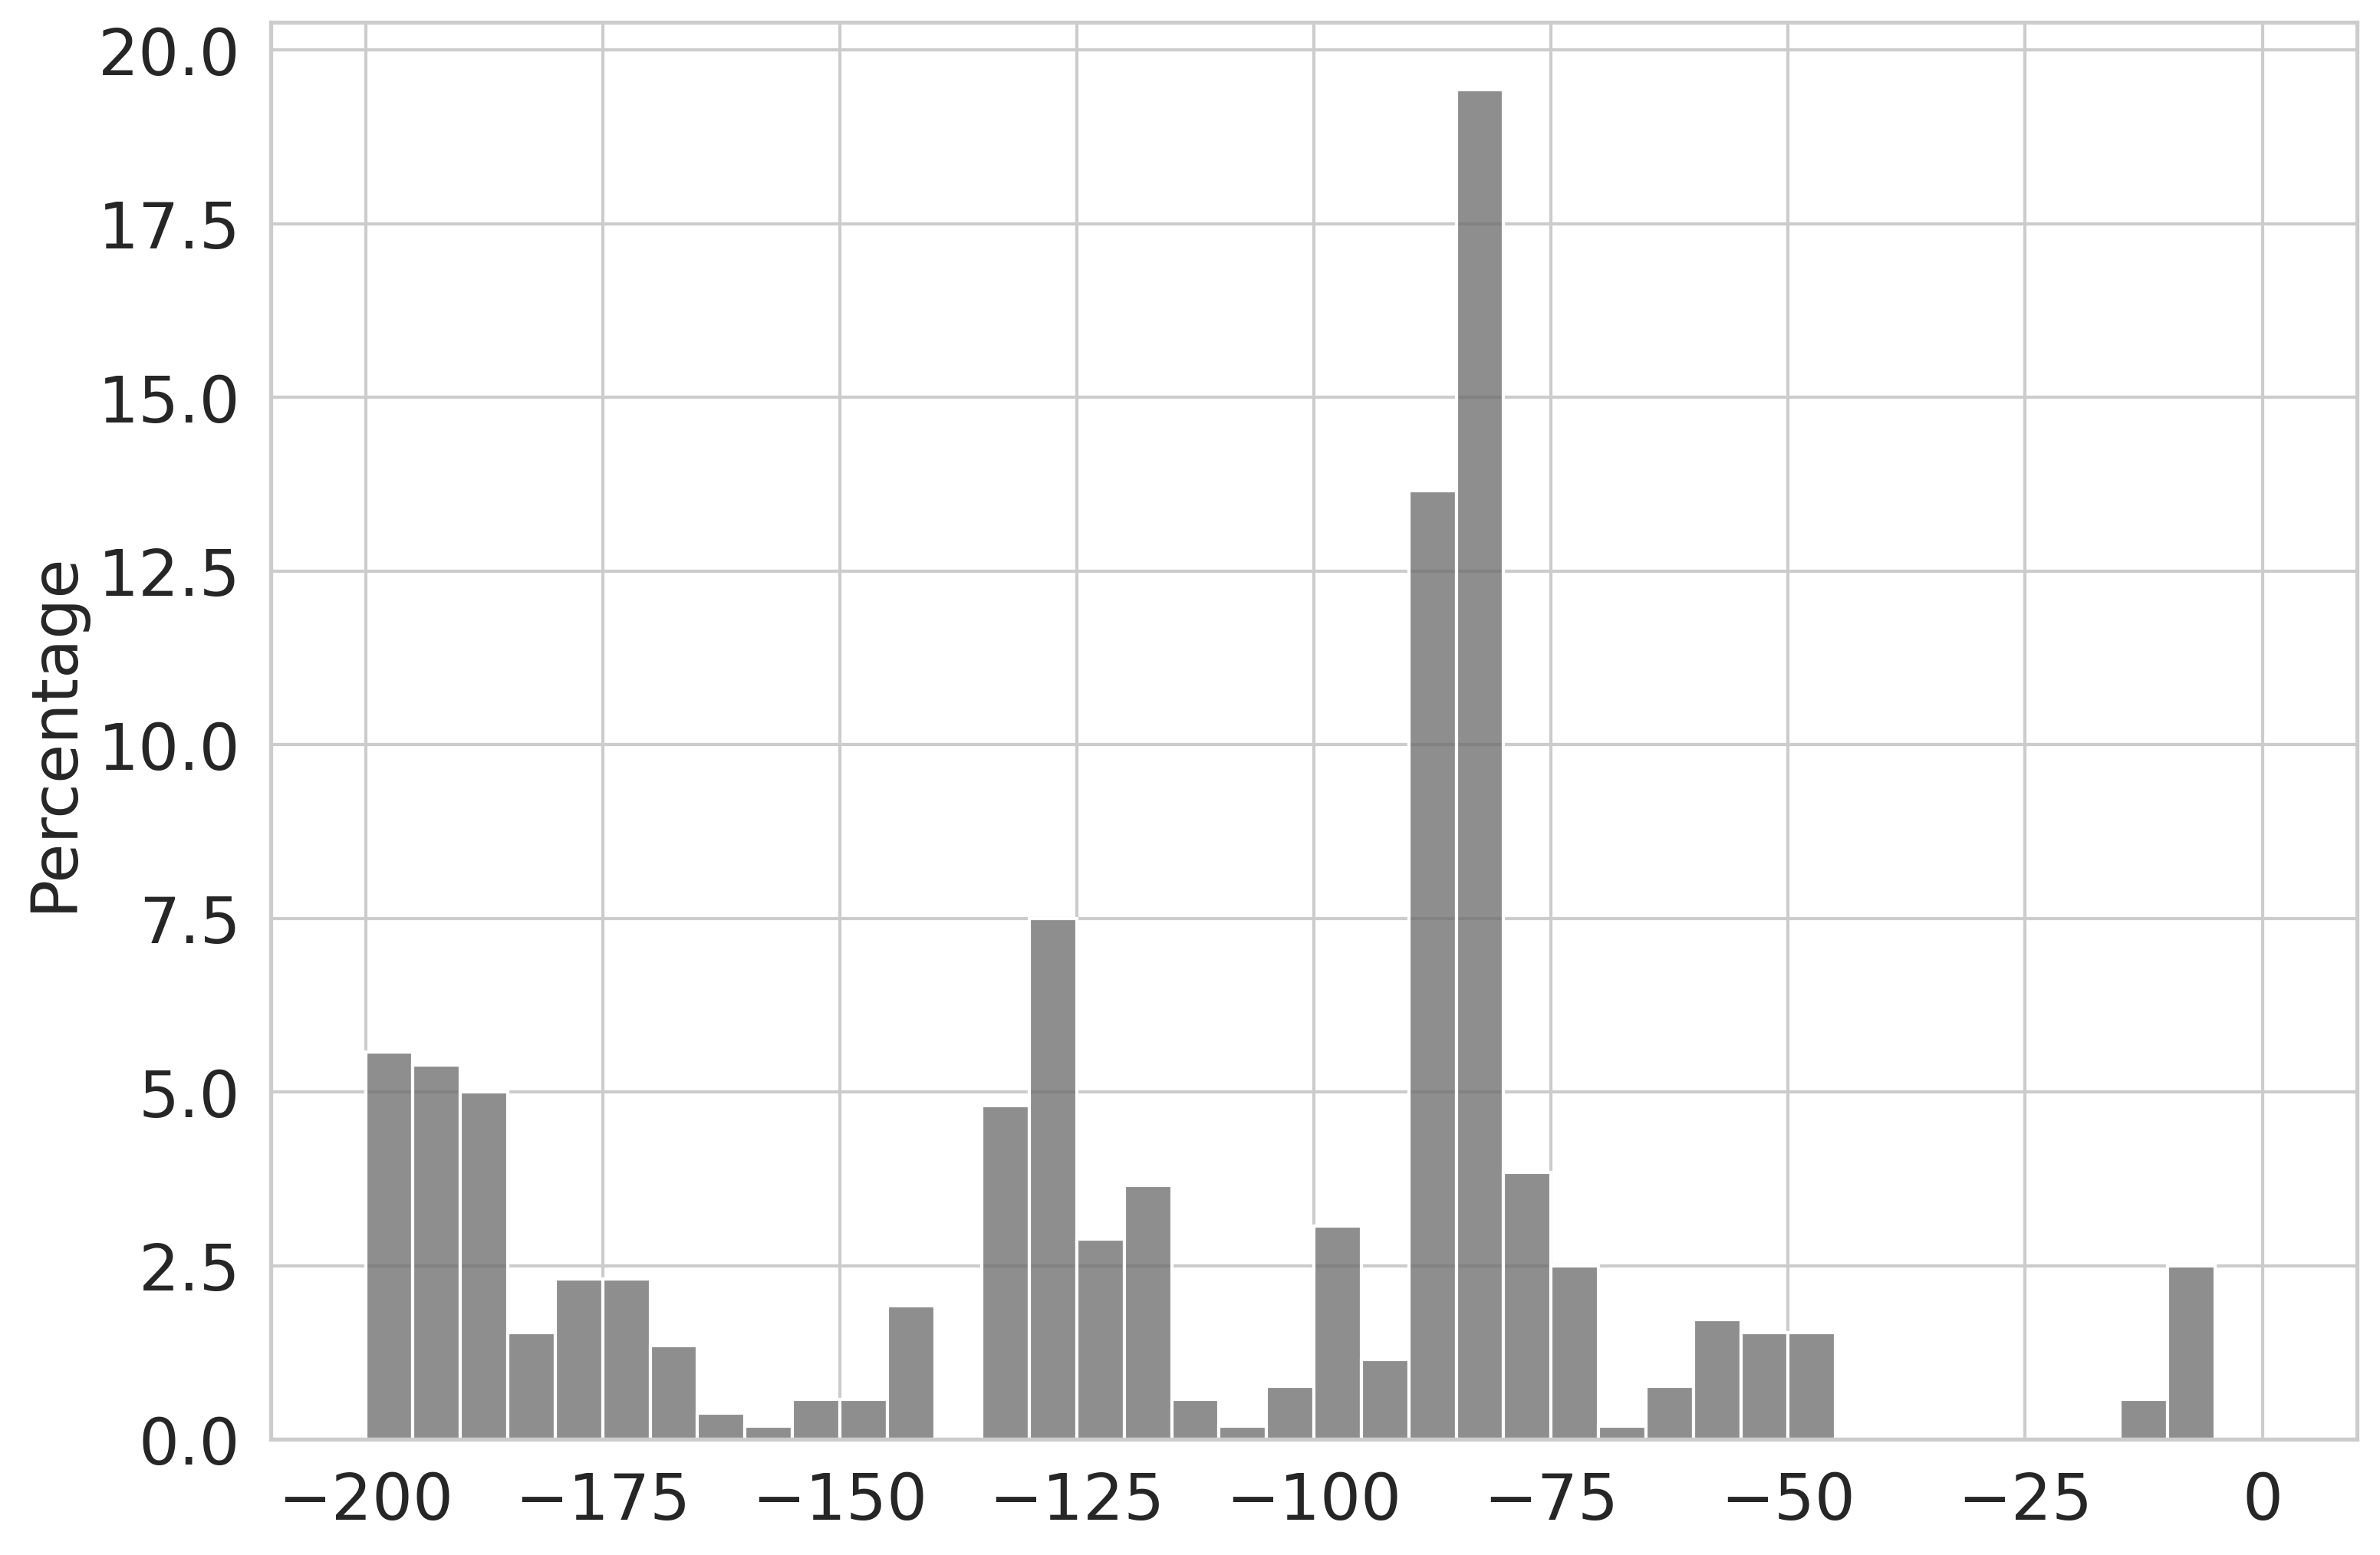

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

index_file = "./data/BOS_Daam1/edit_index_2k.txt"
original_file = "./data/BOS_Daam1/minimize_psi_N2A_daam1_parental_recentered.csv"
data = []
tmp = []
count = 0
with open(index_file) as f, open(original_file) as psi_f:
    next(psi_f)
    psi = float(next(psi_f).split(',')[0])
    for line in f:
        if '>' in line:
            offset = -200
            if tmp:
                data.extend(tmp)
                psi = float(next(psi_f).split(',')[0])
            tmp = []
        else:
            if any([x in line for x in ["E1I1", "AI2", "I2E2"]]):  #"E1I1", "I1A", "AI2", "I2E2"
                continue
            try:
                indices = [int(x)+offset for x in line.strip().split('\t')[1].split(' ')]
            except:
                continue
            tmp.extend(indices)


            
sns.set(rc={'figure.figsize':(11.7,8), "figure.dpi":300, "figure.dpi":300})
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 20})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
ax = sns.histplot(data, stat="percent",binrange=(-200,0),bins=40, color="dimgrey")
plt.ylabel('Percentage', fontsize = 20)
